In [1]:
import pandas as pd
import numpy as np

def preprocess(df_train, df_test):
	# Bước 1: Nối hai bảng train và test
	df_train['dataset'] = 'train'
	df_test['dataset'] = 'test'
	df_combined = pd.concat([df_train, df_test], axis=0)

	# Bước 2: Lọc bỏ các ngày đóng cửa
	df_combined = df_combined.dropna(subset=['high', 'low'], how='all')

	# Bước 3: Tạo cột target
	df_combined['target'] = (df_combined['high'] + df_combined['low']) / 2

	# Bước 4: Trích xuất và mã hóa chu kỳ cho các đặc trưng thời gian
	df_combined['datetime'] = pd.to_datetime(df_combined['time'])

	# Mã hóa chu kỳ cho tháng (1-12)
	df_combined['month'] = df_combined['datetime'].dt.month
	df_combined['month_sin'] = np.sin(2 * np.pi * df_combined['month'] / 12)
	df_combined['month_cos'] = np.cos(2 * np.pi * df_combined['month'] / 12)

	# Mã hóa chu kỳ cho ngày trong tuần (0-6)
	df_combined['day_of_week'] = df_combined['datetime'].dt.dayofweek
	df_combined['dow_sin'] = np.sin(2 * np.pi * df_combined['day_of_week'] / 7)
	df_combined['dow_cos'] = np.cos(2 * np.pi * df_combined['day_of_week'] / 7)

	# Mã hóa chu kỳ cho ngày trong tháng (1-31)
	df_combined['day'] = df_combined['datetime'].dt.day
	df_combined['day_sin'] = np.sin(2 * np.pi * df_combined['day'] / 31)
	df_combined['day_cos'] = np.cos(2 * np.pi * df_combined['day'] / 31)

	# Mã hóa chu kỳ cho ngày trong năm (1-366)
	df_combined['day_of_year'] = df_combined['datetime'].dt.dayofyear
	df_combined['doy_sin'] = np.sin(2 * np.pi * df_combined['day_of_year'] / 366)
	df_combined['doy_cos'] = np.cos(2 * np.pi * df_combined['day_of_year'] / 366)

	# Bước 5: Đặt time làm index
	df_combined = df_combined.set_index('time')
	df_combined.drop(['datetime', 'month', 'day_of_week', 'day', 'day_of_year'], axis=1, inplace=True)

	# Bước 6: Tạo nhiều đặc trưng lag hơn cho target
	lag_values = [1, 2, 3, 5, 7, 10, 14, 21, 30, 45, 60, 90]
	for lag in lag_values:
		df_combined[f'target_lag_{lag}'] = df_combined['target'].shift(lag)

	# Bước 7: Tạo các đặc trưng thống kê từ giá trị lag
	# Trung bình động cho nhiều khoảng thời gian
	window_sizes = [5, 10, 20, 30, 60]
	for window in window_sizes:
		# Trung bình động
		df_combined[f'target_ma_{window}'] = df_combined['target'].rolling(window=window, min_periods=1).mean()
		
		# Độ lệch chuẩn động
		df_combined[f'target_std_{window}'] = df_combined['target'].rolling(window=window, min_periods=2).std()
		
		# Trung bình động trọng số theo thời gian (gần đây có trọng số cao hơn)
		weights = np.arange(1, window + 1)
		df_combined[f'target_ema_{window}'] = df_combined['target'].ewm(span=window, min_periods=1).mean()

	# Bước 8: Tạo đặc trưng về biến động giá
	# Chênh lệch giá
	for period in [1, 3, 5, 7, 14, 21]:
		df_combined[f'price_change_{period}d'] = df_combined['target'].diff(period)
		df_combined[f'pct_change_{period}d'] = df_combined['target'].pct_change(period) * 100

	# Bước 9: Tạo đặc trưng về volatility
	for window in [7, 14, 30]:
		# Volatility (dựa trên độ lệch chuẩn của % thay đổi)
		df_combined[f'volatility_{window}d'] = df_combined['pct_change_1d'].rolling(window=window).std()

	# Bước 10: Tạo đặc trưng momentum
	for window in [5, 10, 20, 30]:
		# Rate of Change (ROC)
		df_combined[f'roc_{window}'] = (df_combined['target'] / df_combined['target'].shift(window) - 1) * 100
		
		# Relative Strength Index (RSI) - Đơn giản hóa
		delta = df_combined['target'].diff()
		gain = delta.where(delta > 0, 0)
		loss = -delta.where(delta < 0, 0)
		avg_gain = gain.rolling(window=window, min_periods=1).mean()
		avg_loss = loss.rolling(window=window, min_periods=1).mean()
		rs = avg_gain / avg_loss.replace(0, np.nan)
		df_combined[f'rsi_{window}'] = 100 - (100 / (1 + rs))

	# Bước 11: Tạo đặc trưng về biên độ giá
	df_combined['high_low_range'] = df_combined['high'] - df_combined['low']
	df_combined['high_low_range_pct'] = df_combined['high_low_range'] / df_combined['target'] * 100

	# Bước 12: Tạo đặc trưng xu hướng
	# Định nghĩa xu hướng - 1:tăng, -1:giảm, 0:không đổi
	df_combined['trend'] = np.sign(df_combined['price_change_1d'])

	# Số ngày xu hướng kéo dài liên tục
	df_combined['trend_duration'] = 0
	trend = 0
	prev_trend = 0
	for i in range(len(df_combined)):
		current_trend = df_combined['trend'].iloc[i]
		if pd.isna(current_trend):
			trend = 0
		elif current_trend == prev_trend:
			trend += 1
		else:
			trend = 1
		df_combined.loc[df_combined.index[i], 'trend_duration'] = trend
		prev_trend = current_trend if not pd.isna(current_trend) else 0

	# Bước 13: Tách lại thành tập train và test
	df_train_processed = df_combined[df_combined['dataset'] == 'train'].drop('dataset', axis=1)
	df_test_processed = df_combined[df_combined['dataset'] == 'test'].drop('dataset', axis=1)

	# Bước 14: Với tập train, loại bỏ các hàng có NaN
	df_train_processed = df_train_processed.dropna()

	# Bước 15: Reset index cho cả hai tập
	df_train_processed = df_train_processed.reset_index(drop=True)
	df_test_processed = df_test_processed.reset_index(drop=True)

	return df_train_processed, df_test_processed

# XGBoost v1

## 1. Confidence Interval Prediction

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import norm

def prepare_advanced_features(df, window_size=20, is_test=False, df_train=None):
    """Tạo đặc trưng nâng cao với các thành phần trực tiếp tính toán High-Low
    
    Parameters:
    df (pandas.DataFrame): DataFrame với dữ liệu cần xử lý
    window_size (int): Kích thước cửa sổ cho các đặc trưng lag và rolling
    is_test (bool): Đánh dấu nếu đây là tập test để sử dụng dữ liệu train cho các đặc trưng đầu tiên
    df_train (pandas.DataFrame): DataFrame của tập train (chỉ cần khi is_test=True)
    
    Returns:
    tuple: X, y_target, y_high, y_low, df_features
    """
    df_features = df.copy()
    
    # Nếu đây là tập test, nối với cuối tập train để tính các đặc trưng liên tục
    if is_test and df_train is not None:
        # Lấy window_size ngày cuối cùng từ tập train
        train_tail = df_train.tail(window_size).copy()
        # Nối với tập test để tính các đặc trưng
        df_combined = pd.concat([train_tail, df_features], axis=0)
        # Sử dụng df_combined để tính toán các đặc trưng
        df_working = df_combined.copy()
    else:
        df_working = df_features.copy()
    
    # 1. Tính trực tiếp high-low features
    df_working['hl_range'] = df_working['high'] - df_working['low']
    df_working['hl_pct'] = df_working['hl_range'] / df_working['target'] * 100
    
    # Lag cho high, low và range
    for lag in range(1, window_size + 1):
        df_working[f'high_lag_{lag}'] = df_working['high'].shift(lag)
        df_working[f'low_lag_{lag}'] = df_working['low'].shift(lag)
        df_working[f'hl_range_lag_{lag}'] = df_working['hl_range'].shift(lag)
        df_working[f'hl_pct_lag_{lag}'] = df_working['hl_pct'].shift(lag)
    
    # 2. Tạo các lag và đặc trưng kỹ thuật cơ bản
    for lag in range(1, window_size + 1):
        df_working[f'target_lag_{lag}'] = df_working['target'].shift(lag)
    
    # Moving averages và volatility
    for window in [5, 10, 20]:
        # Target
        df_working[f'ma_{window}'] = df_working['target'].rolling(window=window).mean()
        df_working[f'std_{window}'] = df_working['target'].rolling(window=window).std()
        
        # High-Low range
        df_working[f'hl_range_ma_{window}'] = df_working['hl_range'].rolling(window=window).mean()
        df_working[f'hl_pct_ma_{window}'] = df_working['hl_pct'].rolling(window=window).mean()
    
    # 3. Các đặc trưng giá phái sinh
    # Momentum & Trend
    for period in [1, 5, 10]:
        df_working[f'roc_{period}'] = df_working['target'].pct_change(periods=period) * 100
        df_working[f'high_roc_{period}'] = df_working['high'].pct_change(periods=period) * 100
        df_working[f'low_roc_{period}'] = df_working['low'].pct_change(periods=period) * 100
    
    # 4. Đặc trưng về biến động không đối xứng
    # Tính toán nếu giá có xu hướng mở rộng khoảng dao động lên trên hay xuống dưới
    df_working['upper_expansion'] = df_working['high'] - df_working['target']
    df_working['lower_expansion'] = df_working['target'] - df_working['low']
    df_working['expansion_ratio'] = df_working['upper_expansion'] / df_working['lower_expansion']
    
    # 5. Đặc trưng thống kê cao cấp của khoảng [Low, High]
    for window in [10, 20]:
        # Tính skewness của khoảng cao-thấp
        df_working[f'hl_skew_{window}'] = df_working['hl_range'].rolling(window=window).skew()
        
        # Tính độ lệch giữa target và trung điểm của khoảng [low, high]
        df_working['hl_midpoint'] = (df_working['high'] + df_working['low']) / 2
        df_working[f'target_mid_offset_{window}'] = (df_working['target'] - df_working['hl_midpoint']).rolling(window=window).mean()
    
    # Nếu đây là tập test, chỉ lấy phần dữ liệu test từ df_working
    if is_test and df_train is not None:
        # Chỉ giữ lại phần dữ liệu test (bỏ window_size ngày đầu là từ train)
        df_features_processed = df_working.iloc[window_size:].copy()
    else:
        # Loại bỏ NaN cho tập train
        df_features_processed = df_working.dropna().copy()
    
    # Tách features và targets
    X = df_features_processed.drop(['target', 'high', 'low'], axis=1)
    y_target = df_features_processed['target']
    y_high = df_features_processed['high']
    y_low = df_features_processed['low']
    
    return X, y_target, y_high, y_low, df_features_processed

def train_direct_models(X_train, y_target, y_high, y_low):
    """Huấn luyện mô hình dự đoán trực tiếp High, Low và Target"""
    params = {
        'n_estimators': 500,
        'learning_rate': 0.01,
        'max_depth': 6,
        'min_child_weight': 3,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'random_state': 42
    }
    
    # Huấn luyện mô hình cho target
    print("Huấn luyện mô hình Target...")
    model_target = xgb.XGBRegressor(**params)
    model_target.fit(X_train, y_target)
    
    # Huấn luyện mô hình cho high
    print("Huấn luyện mô hình High...")
    model_high = xgb.XGBRegressor(**params)
    model_high.fit(X_train, y_high)
    
    # Huấn luyện mô hình cho low
    print("Huấn luyện mô hình Low...")
    model_low = xgb.XGBRegressor(**params)
    model_low.fit(X_train, y_low)
    
    return {
        'target': model_target,
        'high': model_high,
        'low': model_low
    }

def train_residual_models(X_train, y_target, y_high, y_low):
    """Huấn luyện mô hình dự đoán độ lệch giữa High/Low và Target"""
    params = {
        'n_estimators': 500,
        'learning_rate': 0.01,
        'max_depth': 5,
        'min_child_weight': 2,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'random_state': 42
    }
    
    # Tính độ lệch
    high_residuals = y_high - y_target
    low_residuals = y_target - y_low
    
    # Thêm đặc trưng về độ lệch vào X
    X_enhanced = X_train.copy()
    
    # Huấn luyện mô hình cho độ lệch lên trên (high - target)
    print("Huấn luyện mô hình độ lệch upper...")
    model_upper = xgb.XGBRegressor(**params)
    model_upper.fit(X_enhanced, high_residuals)
    
    # Huấn luyện mô hình cho độ lệch xuống dưới (target - low)
    print("Huấn luyện mô hình độ lệch lower...")
    model_lower = xgb.XGBRegressor(**params)
    model_lower.fit(X_enhanced, low_residuals)
    
    return {
        'upper': model_upper,
        'lower': model_lower
    }

def predict_with_direct_models(models, X_test):
    """Dự đoán trực tiếp Target, High và Low"""
    pred_target = models['target'].predict(X_test)
    pred_high = models['high'].predict(X_test)
    pred_low = models['low'].predict(X_test)
    
    # Đảm bảo High >= Target >= Low
    for i in range(len(pred_target)):
        pred_high[i] = max(pred_high[i], pred_target[i])
        pred_low[i] = min(pred_low[i], pred_target[i])
    
    return pred_target, pred_high, pred_low

def predict_with_residuals(models, X_test, pred_target):
    """Dự đoán High và Low bằng cách dự đoán độ lệch từ Target"""
    pred_upper = models['upper'].predict(X_test)
    pred_lower = models['lower'].predict(X_test)
    
    # Giới hạn độ lệch ở mức hợp lý
    pred_upper = np.clip(pred_upper, 0.01, np.percentile(pred_upper, 95))
    pred_lower = np.clip(pred_lower, 0.01, np.percentile(pred_lower, 95))
    
    # Tính High và Low từ độ lệch
    pred_high = pred_target + pred_upper
    pred_low = pred_target - pred_lower
    
    return pred_high, pred_low

def create_asymmetric_confidence_intervals(pred_target, pred_std, volatility, high_low_ratio):
    """Tạo khoảng tin cậy không đối xứng dựa vào volatility và tỷ lệ high/low"""
    # Chuẩn hóa volatility về khoảng [0.5, 1.5]
    normalized_vol = 0.5 + volatility / np.max(volatility)
    
    # Tạo khoảng tin cậy không đối xứng
    # Khi high_low_ratio > 1, mở rộng upper bound nhiều hơn
    # Khi high_low_ratio < 1, mở rộng lower bound nhiều hơn
    z_score = 1.645  # ~90% confidence
    
    upper_scale = normalized_vol * np.clip(high_low_ratio, 0.8, 1.2)
    lower_scale = normalized_vol * np.clip(1/high_low_ratio, 0.8, 1.2)
    
    upper_bound = pred_target + z_score * pred_std * upper_scale
    lower_bound = pred_target - z_score * pred_std * lower_scale
    
    return lower_bound, upper_bound

def calculate_adaptive_confidence_intervals(pred_target, pred_high, pred_low, X_test, conf_level=0.9):
    """Tính khoảng tin cậy thích ứng dựa trên conformal prediction"""
    # Tính độ rộng dự đoán ban đầu
    initial_width = pred_high - pred_low
    
    # Tính volatility features từ X_test
    if 'std_10' in X_test.columns:
        volatility = X_test['std_10'].values
    else:
        volatility = np.ones(len(pred_target)) * 0.01
    
    # Tính expansion ratio (high vs low)
    if 'expansion_ratio' in X_test.columns:
        high_low_ratio = X_test['expansion_ratio'].values
    else:
        high_low_ratio = np.ones(len(pred_target))
    
    # Thay thế giá trị NaN nếu có
    high_low_ratio = np.nan_to_num(high_low_ratio, nan=1.0)
    volatility = np.nan_to_num(volatility, nan=0.01)
    
    # Tính độ lệch chuẩn dự đoán
    pred_std = initial_width / 2 * 0.7  # Scale down a bit
    
    # Tạo khoảng tin cậy không đối xứng
    lower_bound, upper_bound = create_asymmetric_confidence_intervals(
        pred_target, pred_std, volatility, high_low_ratio
    )
    
    # Hiệu chỉnh cuối cùng để đảm bảo lower <= target <= upper
    lower_bound = np.minimum(lower_bound, pred_target)
    upper_bound = np.maximum(upper_bound, pred_target)
    
    return lower_bound, upper_bound

def train_and_validate_with_calibration(X_train, y_train_target, y_train_high, y_train_low, val_ratio=0.2):
    """Huấn luyện mô hình trên một phần tập huấn luyện và hiệu chỉnh trên phần còn lại"""
    # Chia tập huấn luyện thành train và validation
    val_size = int(len(X_train) * val_ratio)
    train_size = len(X_train) - val_size
    
    # Chia dữ liệu
    X_train_subset = X_train.iloc[:train_size]
    y_train_target_subset = y_train_target.iloc[:train_size]
    y_train_high_subset = y_train_high.iloc[:train_size]
    y_train_low_subset = y_train_low.iloc[:train_size]
    
    X_val = X_train.iloc[train_size:]
    y_val_target = y_train_target.iloc[train_size:]
    y_val_high = y_train_high.iloc[train_size:]
    y_val_low = y_train_low.iloc[train_size:]
    
    # Huấn luyện mô hình trên tập train_subset
    direct_models = train_direct_models(X_train_subset, y_train_target_subset, y_train_high_subset, y_train_low_subset)
    residual_models = train_residual_models(X_train_subset, y_train_target_subset, y_train_high_subset, y_train_low_subset)
    
    # Dự đoán trên tập validation
    direct_pred = predict_with_direct_models(direct_models, X_val)
    residual_pred = predict_with_residuals(residual_models, X_val, direct_pred[0])
    
    # Kết hợp dự đoán
    pred_val_target, pred_val_high, pred_val_low = combine_predictions(
        (direct_pred[0], direct_pred[1], direct_pred[2]), 
        (residual_pred[0], residual_pred[1])
    )
    
    # Tính khoảng tin cậy thích ứng
    adaptive_low, adaptive_high = calculate_adaptive_confidence_intervals(
        pred_val_target, pred_val_high, pred_val_low, X_val
    )
    
    # Tính toán hệ số hiệu chỉnh từ tập validation
    calibration_params = calculate_calibration_params(
        adaptive_low, adaptive_high, 
        y_val_low.values, y_val_high.values
    )
    
    # Huấn luyện lại mô hình trên toàn bộ tập huấn luyện
    final_direct_models = train_direct_models(X_train, y_train_target, y_train_high, y_train_low)
    final_residual_models = train_residual_models(X_train, y_train_target, y_train_high, y_train_low)
    
    return {
        'models': {
            'direct': final_direct_models,
            'residual': final_residual_models
        },
        'calibration_params': calibration_params
    }

def calculate_calibration_params(pred_low, pred_high, true_low, true_high):
    """Tính toán các tham số hiệu chỉnh từ tập validation"""
    # Tính độ rộng dự đoán và thực tế
    pred_width = pred_high - pred_low
    true_width = true_high - true_low
    
    # Tính tỷ lệ độ rộng thực tế/dự đoán
    width_ratios = true_width / pred_width
    
    # Loại bỏ các giá trị NaN và Inf
    width_ratios = width_ratios[~np.isnan(width_ratios) & ~np.isinf(width_ratios)]
    
    # Tính các thống kê hữu ích
    median_ratio = np.median(width_ratios)  # Sử dụng trung vị để tránh ảnh hưởng của outliers
    mean_ratio = np.mean(width_ratios)
    q25_ratio = np.percentile(width_ratios, 25)
    q75_ratio = np.percentile(width_ratios, 75)
    
    # Tính các tham số khác để hiệu chỉnh
    # Ví dụ: tính tỷ lệ không cân đối giữa phần trên và phần dưới
    upper_error = true_high - pred_high
    lower_error = pred_low - true_low
    
    # Tính tỷ lệ mở rộng cho phần trên và phần dưới
    upper_expansion_ratio = np.mean(upper_error[upper_error > 0]) / np.mean(pred_width) if np.any(upper_error > 0) else 0
    lower_expansion_ratio = np.mean(lower_error[lower_error > 0]) / np.mean(pred_width) if np.any(lower_error > 0) else 0
    
    return {
        'median_width_ratio': median_ratio,
        'mean_width_ratio': mean_ratio,
        'q25_width_ratio': q25_ratio,
        'q75_width_ratio': q75_ratio,
        'upper_expansion_ratio': upper_expansion_ratio,
        'lower_expansion_ratio': lower_expansion_ratio
    }

def apply_calibration(pred_low, pred_target, pred_high, calibration_params, scaling_factor=0.9):
    """Áp dụng hiệu chỉnh dựa trên các tham số từ tập validation"""
    # Trích xuất các tham số
    width_ratio = calibration_params['median_width_ratio']  # Sử dụng trung vị để tránh ảnh hưởng của outliers
    upper_expansion = calibration_params['upper_expansion_ratio']
    lower_expansion = calibration_params['lower_expansion_ratio']
    
    # Áp dụng scaling factor
    width_ratio *= scaling_factor
    
    # Tính độ rộng ban đầu
    pred_width = pred_high - pred_low
    
    # Tính độ rộng hiệu chỉnh
    calibrated_width = pred_width * width_ratio
    
    # Tính khoảng tin cậy hiệu chỉnh với mở rộng không đối xứng
    half_width = calibrated_width / 2
    
    # Áp dụng mở rộng không đối xứng
    upper_adjustment = half_width * (1 + upper_expansion)
    lower_adjustment = half_width * (1 + lower_expansion)
    
    calibrated_high = pred_target + upper_adjustment
    calibrated_low = pred_target - lower_adjustment
    
    return calibrated_low, calibrated_high

def combine_predictions(direct_pred, residual_pred, weights=(0.7, 0.3)):
    """Kết hợp hai phương pháp dự đoán với trọng số"""
    w1, w2 = weights
    
    # Giải nén các dự đoán
    direct_target, direct_high, direct_low = direct_pred
    residual_high, residual_low = residual_pred
    
    # Kết hợp dự đoán
    combined_target = direct_target  # Giữ nguyên target
    combined_high = w1 * direct_high + w2 * residual_high
    combined_low = w1 * direct_low + w2 * residual_low
    
    return combined_target, combined_high, combined_low

def run_enhanced_prediction(df_train, df_test, window_size=20, symbol=None):
    """Chạy quy trình dự đoán nâng cao với nhiều phương pháp kết hợp"""
    # 1. Chuẩn bị dữ liệu nâng cao
    print("Chuẩn bị đặc trưng nâng cao cho tập train...")
    X_train, y_train_target, y_train_high, y_train_low, df_train_features = prepare_advanced_features(
        df_train, window_size, is_test=False, df_train=None
    )
    
    print("Chuẩn bị đặc trưng nâng cao cho tập test...")
    X_test, y_test_target, y_test_high, y_test_low, df_test_features = prepare_advanced_features(
        df_test, window_size, is_test=True, df_train=df_train
    )
    
    # In kích thước dữ liệu để kiểm tra
    print(f"Kích thước tập train: {X_train.shape}")
    print(f"Kích thước tập test: {X_test.shape}")
    print(f"Số ngày trong df_test ban đầu: {len(df_test)}")
    print(f"Số ngày trong X_test sau xử lý: {len(X_test)}")
    
    # 2. Huấn luyện và hiệu chỉnh
    print("\nHuấn luyện mô hình với hiệu chỉnh...")
    training_results = train_and_validate_with_calibration(
        X_train, y_train_target, y_train_high, y_train_low, val_ratio=0.2
    )
    
    direct_models = training_results['models']['direct']
    residual_models = training_results['models']['residual']
    calibration_params = training_results['calibration_params']
    
    # 3. Dự đoán với hai phương pháp
    print("\nDự đoán với các phương pháp khác nhau...")
    direct_pred = predict_with_direct_models(direct_models, X_test)
    residual_pred = predict_with_residuals(residual_models, X_test, direct_pred[0])
    
    # 4. Kết hợp dự đoán từ hai phương pháp
    print("Kết hợp các dự đoán...")
    pred_target, pred_high, pred_low = combine_predictions(
        (direct_pred[0], direct_pred[1], direct_pred[2]), 
        (residual_pred[0], residual_pred[1])
    )
    
    # 5. Tạo khoảng tin cậy theo nhiều phương pháp
    
    # 5.1 Phương pháp 1: Khoảng tin cậy thích ứng
    print("Tính khoảng tin cậy thích ứng...")
    adaptive_low, adaptive_high = calculate_adaptive_confidence_intervals(
        pred_target, pred_high, pred_low, X_test
    )
    
    # 5.2 Phương pháp 2: Khoảng tin cậy được hiệu chỉnh (với tham số từ validation)
    print("Hiệu chỉnh khoảng tin cậy...")
    calibrated_low, calibrated_high = apply_calibration(
        adaptive_low, pred_target, adaptive_high, 
        calibration_params,
        scaling_factor=0.85  # Thu hẹp thêm 15%
    )
    
    # 6. Kết hợp cuối cùng: weighted ensemble của cả hai phương pháp
    final_low = 0.4 * adaptive_low + 0.6 * calibrated_low
    final_high = 0.4 * adaptive_high + 0.6 * calibrated_high
    
    # 7. Đánh giá các phương pháp
    print("\nĐánh giá mô hình:")
    
    # 7.1 Đánh giá phương pháp thích ứng
    adaptive_metrics = evaluate_method(
        adaptive_low, pred_target, adaptive_high, 
        y_test_target.values, y_test_low.values, y_test_high.values,
        "Khoảng tin cậy thích ứng"
    )
    
    # 7.2 Đánh giá phương pháp hiệu chỉnh
    calibrated_metrics = evaluate_method(
        calibrated_low, pred_target, calibrated_high,
        y_test_target.values, y_test_low.values, y_test_high.values,
        "Khoảng tin cậy hiệu chỉnh"
    )
    
    # 7.3 Đánh giá phương pháp kết hợp cuối cùng
    final_metrics = evaluate_method(
        final_low, pred_target, final_high,
        y_test_target.values, y_test_low.values, y_test_high.values,
        "Khoảng tin cậy kết hợp tối ưu"
    )
    
    # 8. Vẽ biểu đồ cho phương pháp tốt nhất
    plot_predictions(
        final_low, pred_target, final_high,
        y_test_target.values, y_test_low.values, y_test_high.values,
        "XGBoost với khoảng tin cậy tối ưu",
        symbol
    )
    
    # 9. Feature importance
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': direct_models['target'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # print("\nTop 10 đặc trưng quan trọng nhất:")
    # print(importance_df.head(10))
    
    return {
        'models': {
            'direct': direct_models,
            'residual': residual_models
        },
        'predictions': {
            'target': pred_target,
            'high': pred_high,
            'low': pred_low,
            'final_low': final_low,
            'final_high': final_high
        },
        'metrics': {
            'adaptive': adaptive_metrics,
            'calibrated': calibrated_metrics,
            'final': final_metrics
        }
    }

def evaluate_method(lower, median, upper, y_test, test_low, test_high, method_name):
    """Đánh giá phương pháp dự đoán"""
    # Tính các độ đo
    rmse = np.sqrt(mean_squared_error(y_test, median))
    mape = mean_absolute_percentage_error(y_test, median)
    r2 = r2_score(y_test, median)
    
    # Tính % khoảng tin cậy bao phủ khoảng [low, high]
    ci_contains_range = np.sum((lower <= test_low) & (upper >= test_high))
    ci_coverage_pct = ci_contains_range / len(median) * 100
    
    # Tính % dự đoán trong khoảng [low, high]
    pred_in_range = np.sum((median >= test_low) & (median <= test_high))
    pred_in_range_pct = pred_in_range / len(median) * 100
    
    # Tính độ rộng khoảng tin cậy
    ci_width = upper - lower
    actual_range_width = test_high - test_low
    avg_ci_width = np.mean(ci_width)
    avg_range_width = np.mean(actual_range_width)
    width_ratio = avg_ci_width / avg_range_width
    
    print(f"\n--- {method_name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Khoảng tin cậy bao phủ [Low, High]: {ci_coverage_pct:.2f}%")
    print(f"Dự đoán nằm trong [Low, High]: {pred_in_range_pct:.2f}%")
    print(f"Tỷ lệ độ rộng (CI/Actual): {width_ratio:.4f}")
    
    return {
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'ci_coverage': ci_coverage_pct,
        'pred_in_range': pred_in_range_pct,
        'width_ratio': width_ratio
    }

def plot_predictions(lower, median, upper, y_test, test_low, test_high, title, symbol):
    """Vẽ dự đoán và khoảng tin cậy"""
    plt.figure(figsize=(14, 7))
    x = np.arange(len(median))
    
    # Vẽ khoảng tin cậy
    plt.fill_between(x, lower, upper, alpha=0.3, color='blue', label='Khoảng tin cậy')
    
    # Vẽ khoảng [low, high] thực tế
    plt.fill_between(x, test_low, test_high, alpha=0.3, color='green', label='Khoảng [Low, High] thực tế')
    
    # Vẽ dự đoán
    plt.plot(x, median, color='red', linewidth=1.5, label='Dự đoán Target')
    
    # Vẽ giá trị thực tế
    plt.plot(x, y_test, color='black', linewidth=1.5, label='Target thực tế')
    
    if symbol is not None:
        plt.title(f"So sánh dự đoán và khoảng tin cậy với khoảng [Low, High] thực tế - {title} ({symbol})")
    else:
        plt.title(f"So sánh dự đoán và khoảng tin cậy với khoảng [Low, High] thực tế - {title}")
        
    plt.xlabel("Thời gian")
    plt.ylabel("Giá")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()   

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (370, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.0795
MAPE: 0.0026
R² Score: 0.9725
Khoảng tin cậy bao phủ [Low, High]: 45.95%
Dự đoán nằm trong [Low, High]: 91.89%
Tỷ lệ độ rộng (CI/Actual): 1.3906

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.0795
MAPE: 0.0026
R² Score: 0.9725
Khoảng tin cậy b

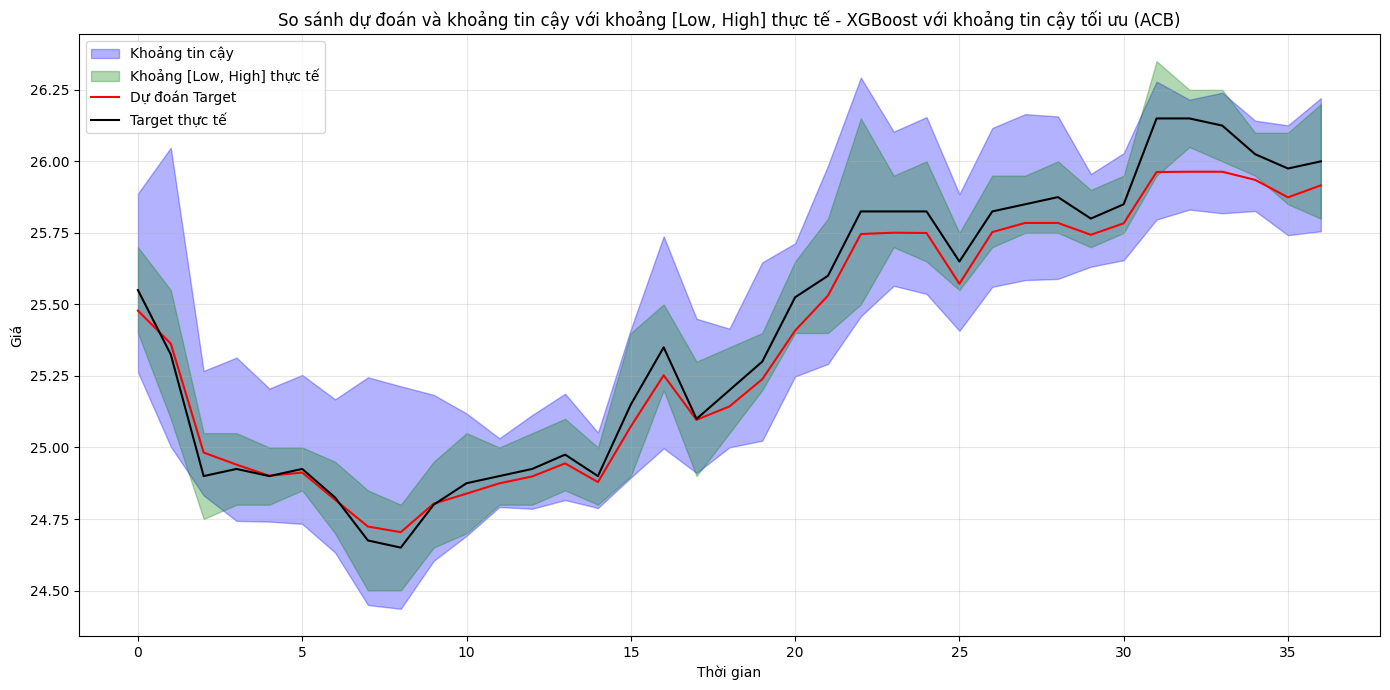

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (377, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.5990
MAPE: 0.0041
R² Score: 0.9284
Khoảng tin cậy bao phủ [Low, High]: 29.73%
Dự đoán nằm trong [Low, High]: 89.19%
Tỷ lệ độ rộng (CI/Actual): 0.9962

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.5990
MAPE: 0.0041
R² Score: 0.9284
Khoảng tin cậy b

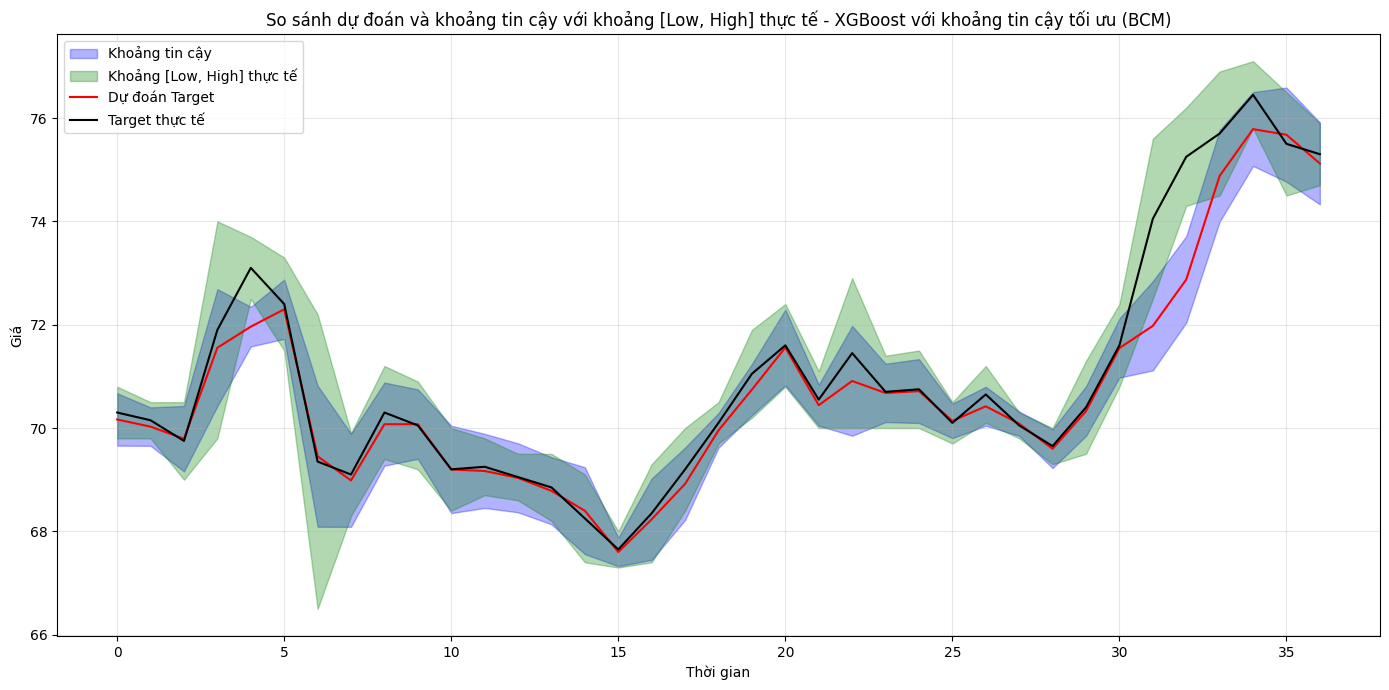

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (367, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.0614
MAPE: 0.0013
R² Score: 0.9935
Khoảng tin cậy bao phủ [Low, High]: 72.97%
Dự đoán nằm trong [Low, High]: 100.00%
Tỷ lệ độ rộng (CI/Actual): 1.4058

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.0614
MAPE: 0.0013
R² Score: 0.9935
Khoảng tin cậy 

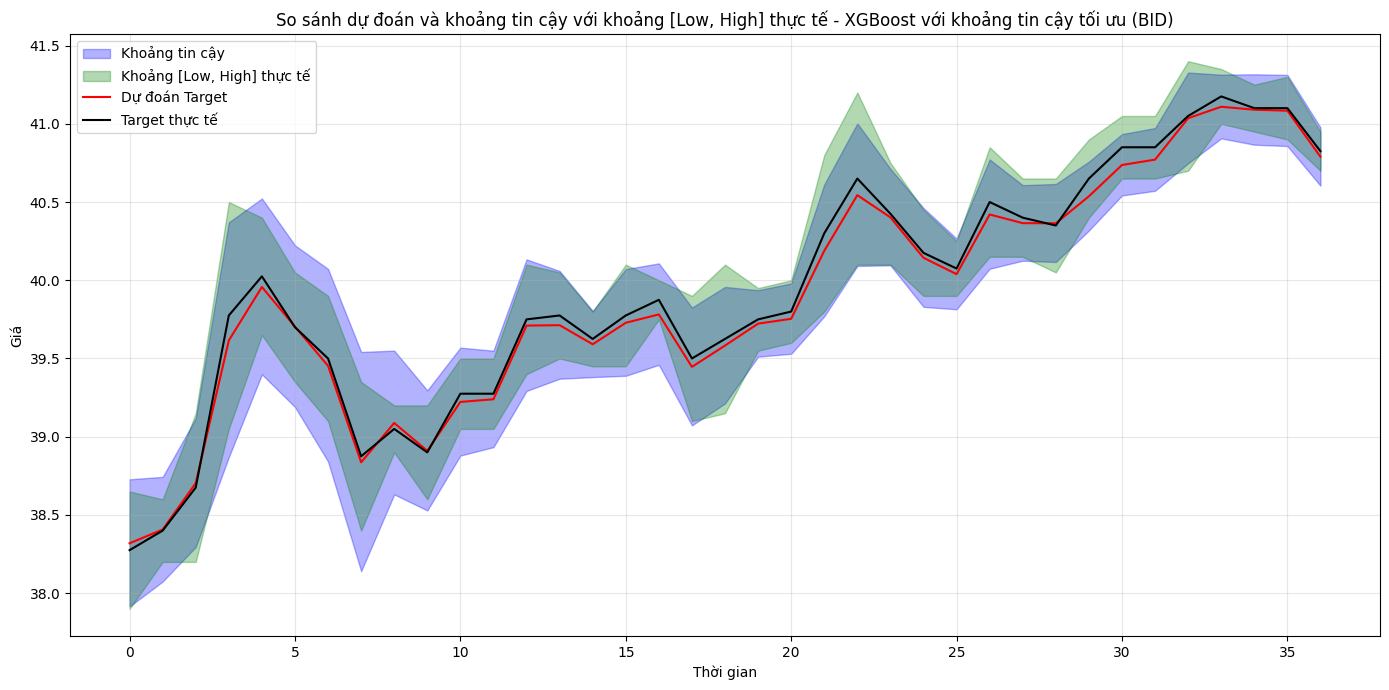

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (379, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 5.2341
MAPE: 0.0758
R² Score: -2.0843
Khoảng tin cậy bao phủ [Low, High]: 13.51%
Dự đoán nằm trong [Low, High]: 10.81%
Tỷ lệ độ rộng (CI/Actual): 1.2138

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 5.2341
MAPE: 0.0758
R² Score: -2.0843
Khoảng tin cậy

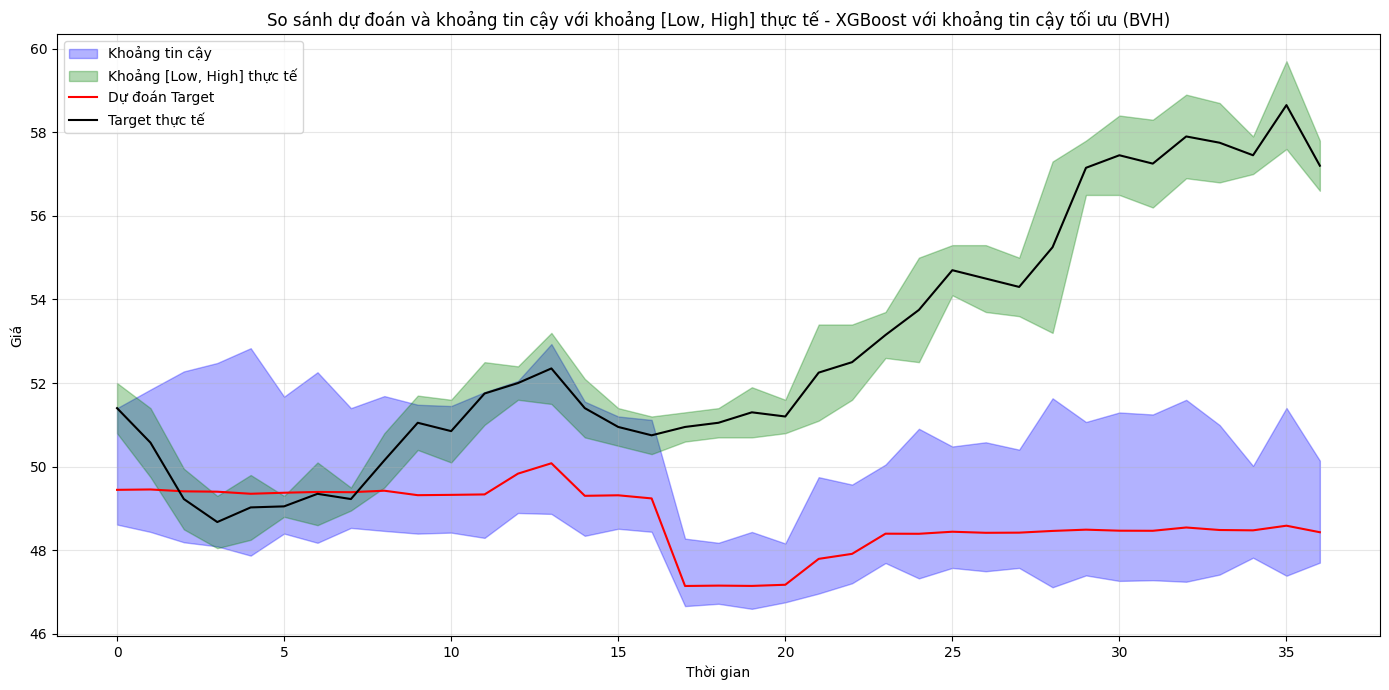

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (374, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 2.5195
MAPE: 0.0478
R² Score: -1.2197
Khoảng tin cậy bao phủ [Low, High]: 2.70%
Dự đoán nằm trong [Low, High]: 27.03%
Tỷ lệ độ rộng (CI/Actual): 1.2093

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 2.5195
MAPE: 0.0478
R² Score: -1.2197
Khoảng tin cậy 

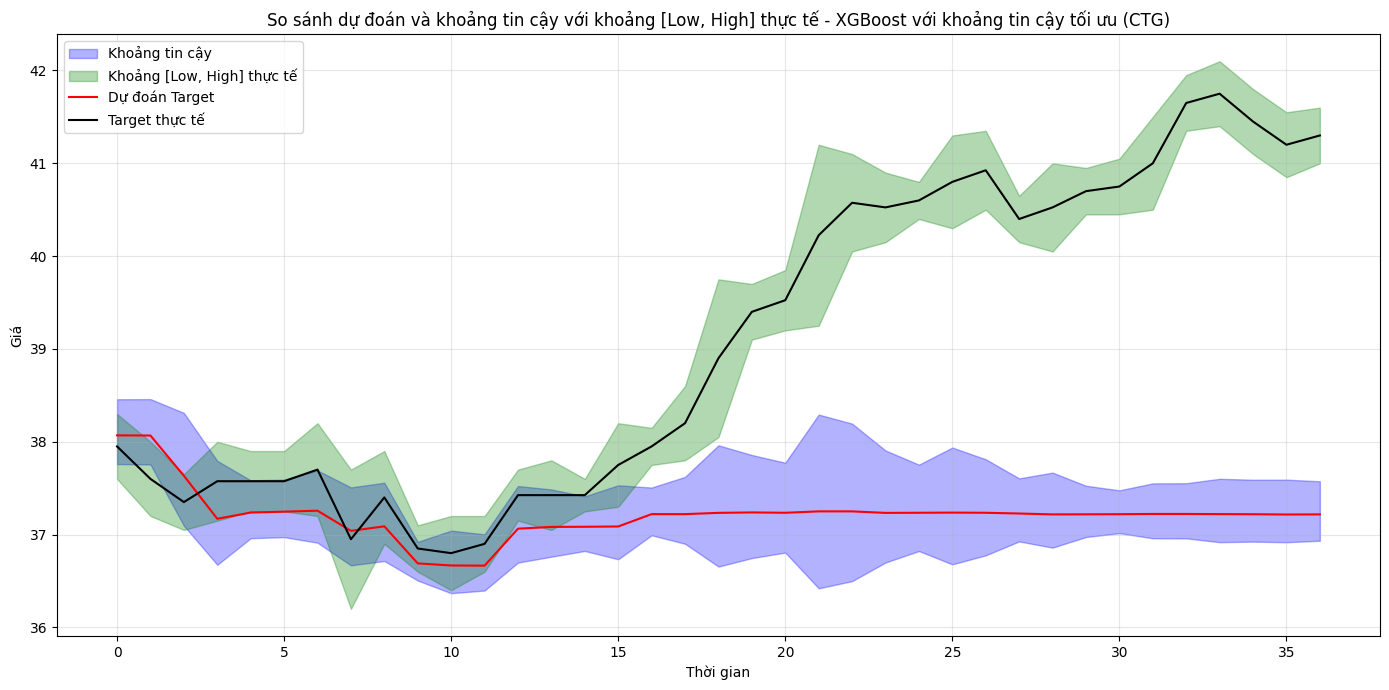

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (355, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 7.0959
MAPE: 0.0450
R² Score: -2.9176
Khoảng tin cậy bao phủ [Low, High]: 2.70%
Dự đoán nằm trong [Low, High]: 2.70%
Tỷ lệ độ rộng (CI/Actual): 1.9406

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 7.0959
MAPE: 0.0450
R² Score: -2.9176
Khoảng tin cậy b

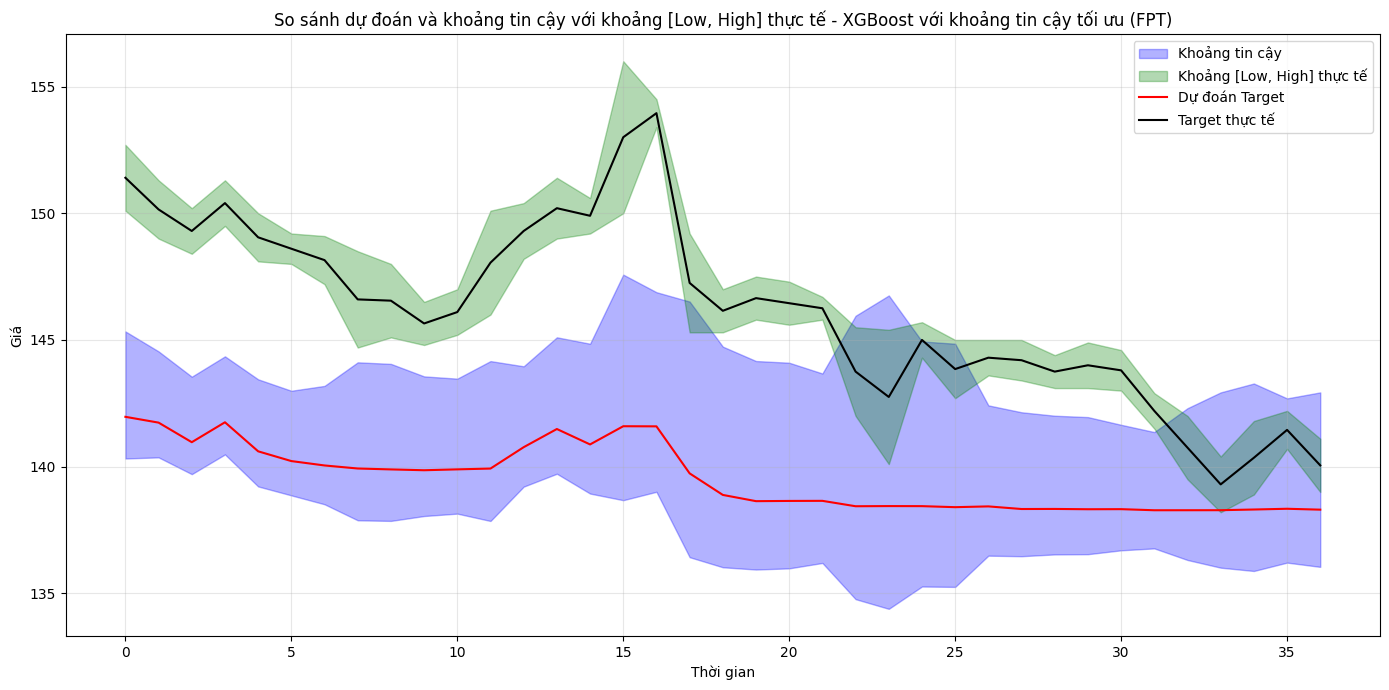

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (377, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.5486
MAPE: 0.0065
R² Score: 0.2003
Khoảng tin cậy bao phủ [Low, High]: 13.51%
Dự đoán nằm trong [Low, High]: 59.46%
Tỷ lệ độ rộng (CI/Actual): 0.9476

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.5486
MAPE: 0.0065
R² Score: 0.2003
Khoảng tin cậy b

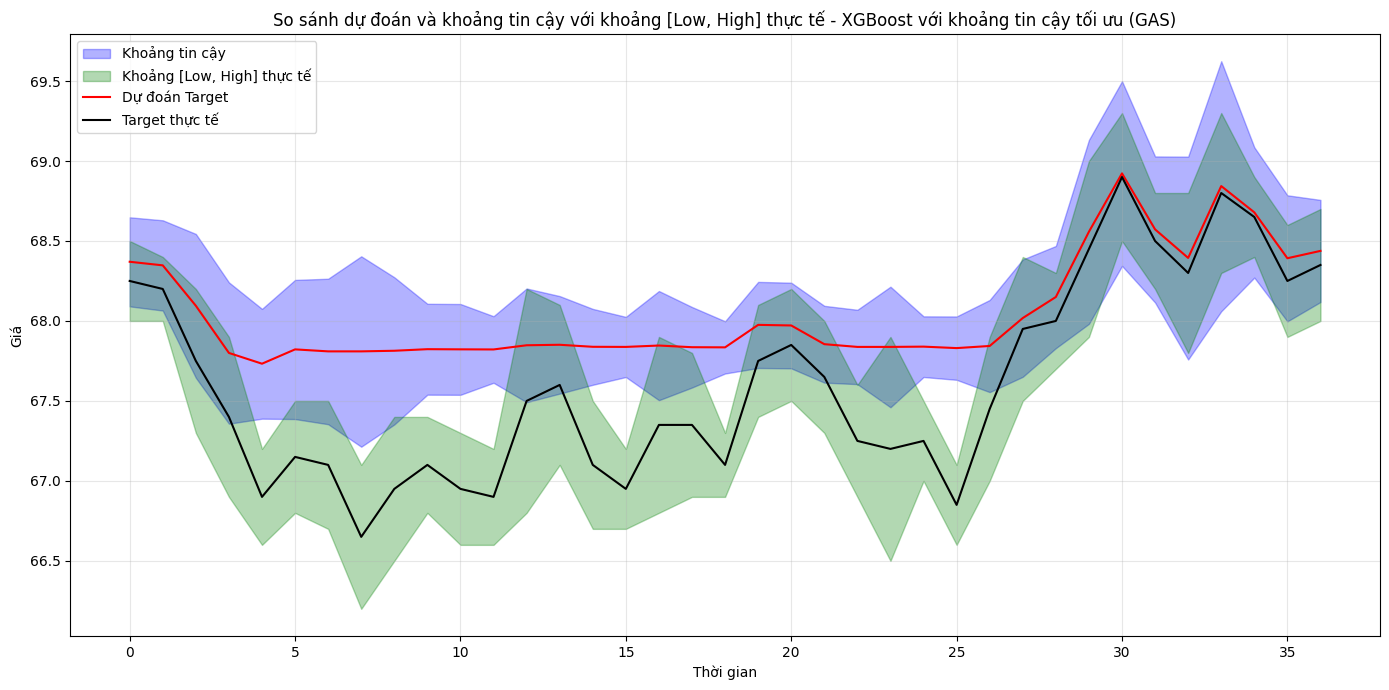

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (363, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.1758
MAPE: 0.0049
R² Score: 0.9858
Khoảng tin cậy bao phủ [Low, High]: 27.03%
Dự đoán nằm trong [Low, High]: 91.89%
Tỷ lệ độ rộng (CI/Actual): 1.1877

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.1758
MAPE: 0.0049
R² Score: 0.9858
Khoảng tin cậy b

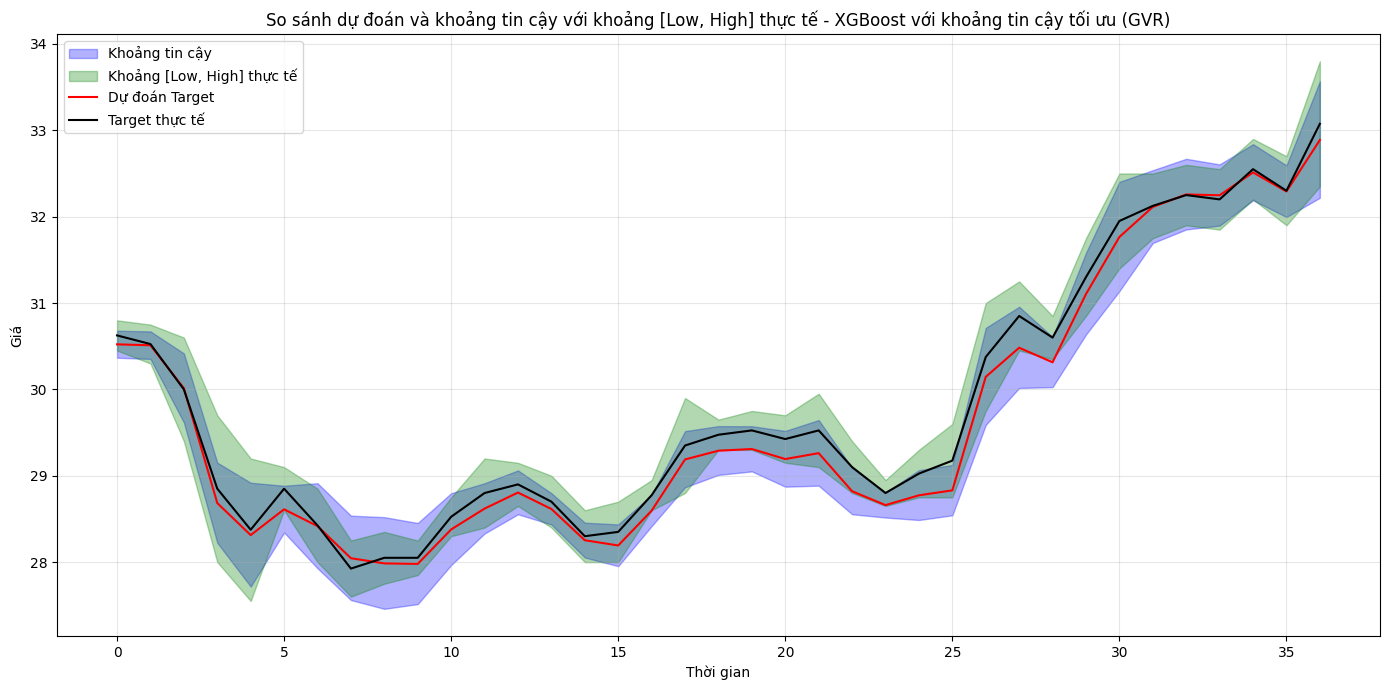

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (356, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.2317
MAPE: 0.0068
R² Score: 0.9150
Khoảng tin cậy bao phủ [Low, High]: 13.51%
Dự đoán nằm trong [Low, High]: 78.38%
Tỷ lệ độ rộng (CI/Actual): 1.2130

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.2317
MAPE: 0.0068
R² Score: 0.9150
Khoảng tin cậy b

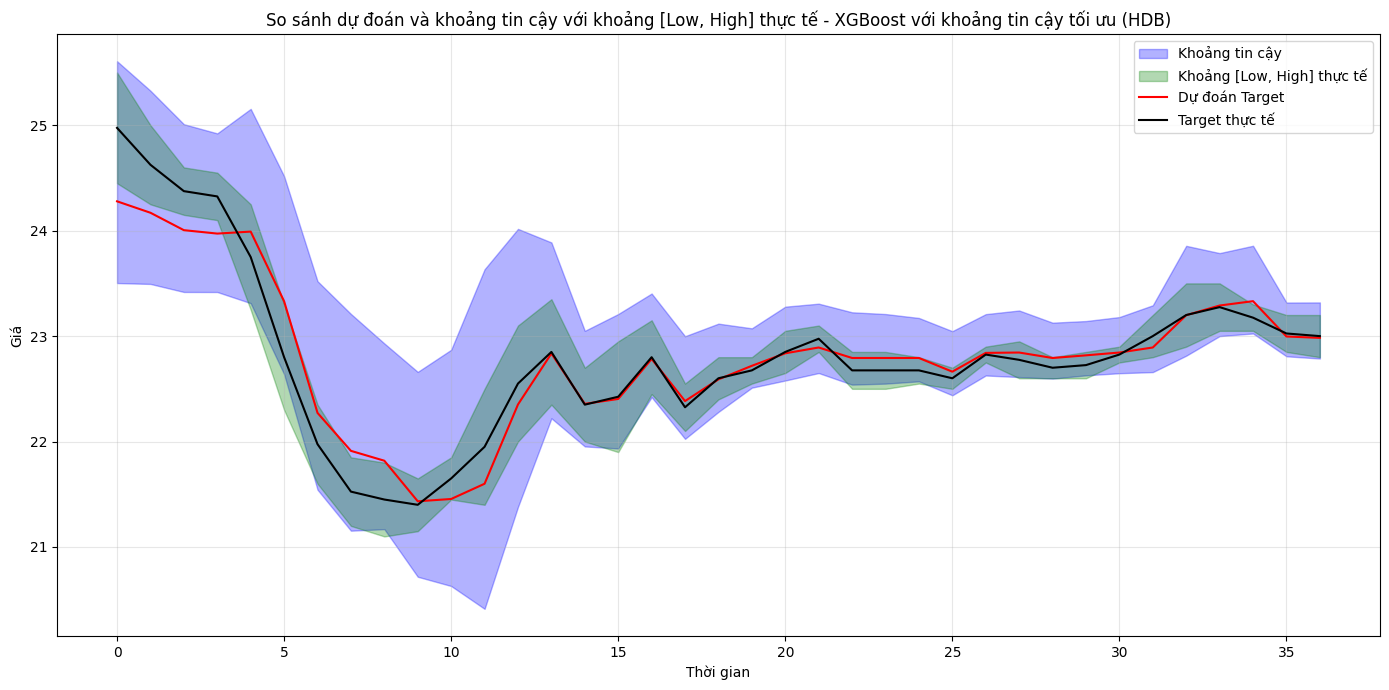

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (371, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.0476
MAPE: 0.0011
R² Score: 0.9940
Khoảng tin cậy bao phủ [Low, High]: 59.46%
Dự đoán nằm trong [Low, High]: 100.00%
Tỷ lệ độ rộng (CI/Actual): 1.1967

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.0476
MAPE: 0.0011
R² Score: 0.9940
Khoảng tin cậy 

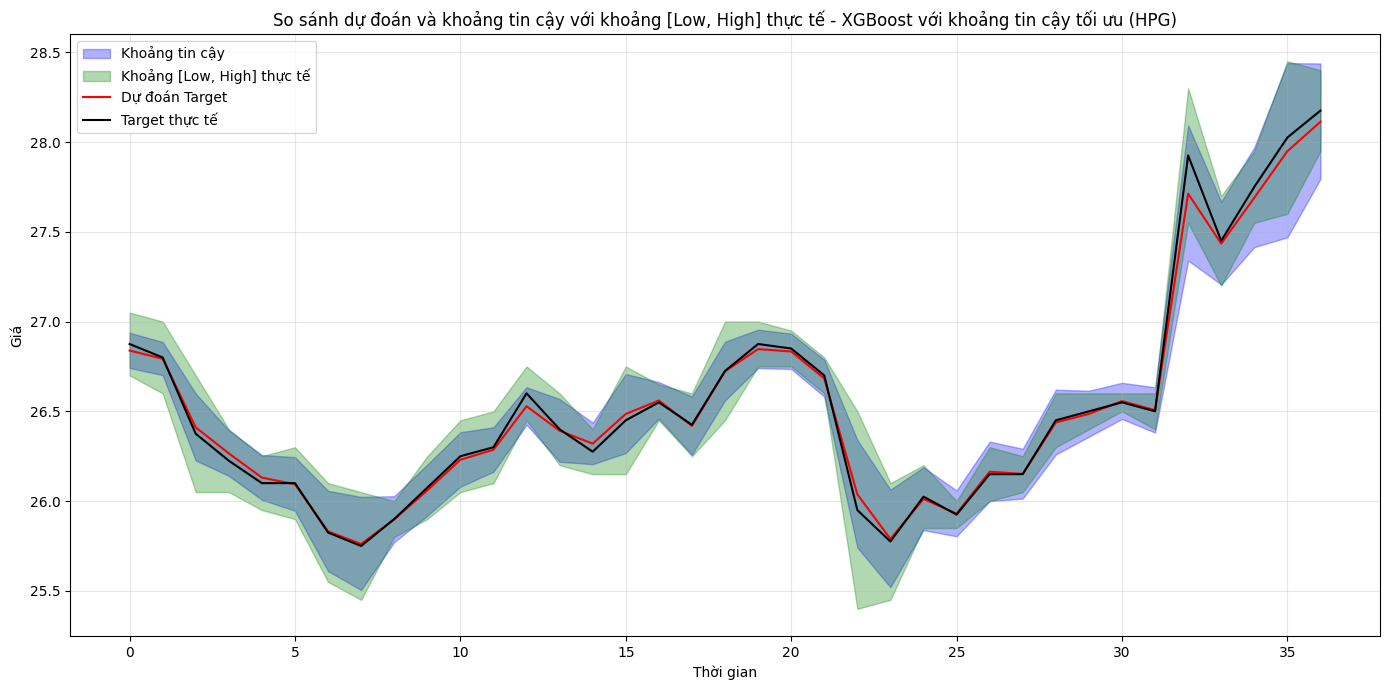

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (356, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 5.3046
MAPE: 0.1259
R² Score: -2.7422
Khoảng tin cậy bao phủ [Low, High]: 0.00%
Dự đoán nằm trong [Low, High]: 5.41%
Tỷ lệ độ rộng (CI/Actual): 0.4859

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 5.3046
MAPE: 0.1259
R² Score: -2.7422
Khoảng tin cậy b

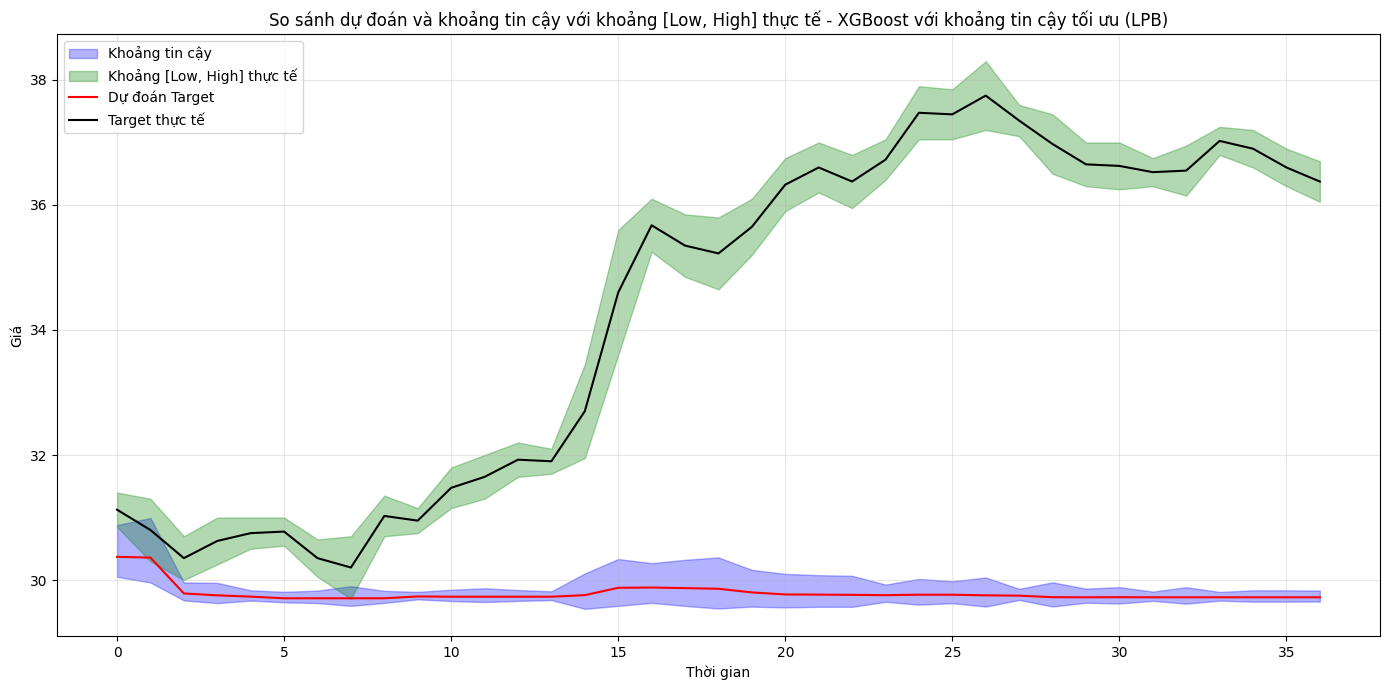

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (373, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.4470
MAPE: 0.0141
R² Score: 0.5486
Khoảng tin cậy bao phủ [Low, High]: 21.62%
Dự đoán nằm trong [Low, High]: 51.35%
Tỷ lệ độ rộng (CI/Actual): 1.2600

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.4470
MAPE: 0.0141
R² Score: 0.5486
Khoảng tin cậy b

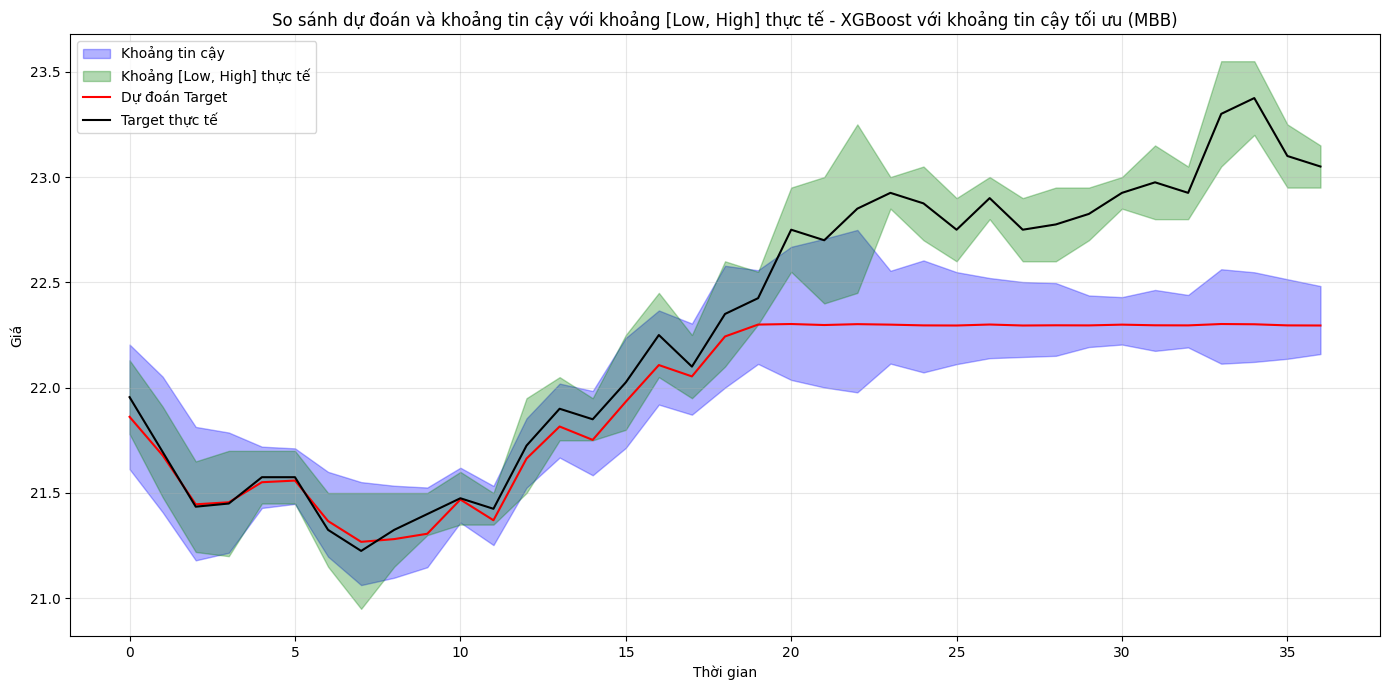

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (375, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.1379
MAPE: 0.0016
R² Score: 0.9897
Khoảng tin cậy bao phủ [Low, High]: 56.76%
Dự đoán nằm trong [Low, High]: 100.00%
Tỷ lệ độ rộng (CI/Actual): 1.2271

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.1379
MAPE: 0.0016
R² Score: 0.9897
Khoảng tin cậy 

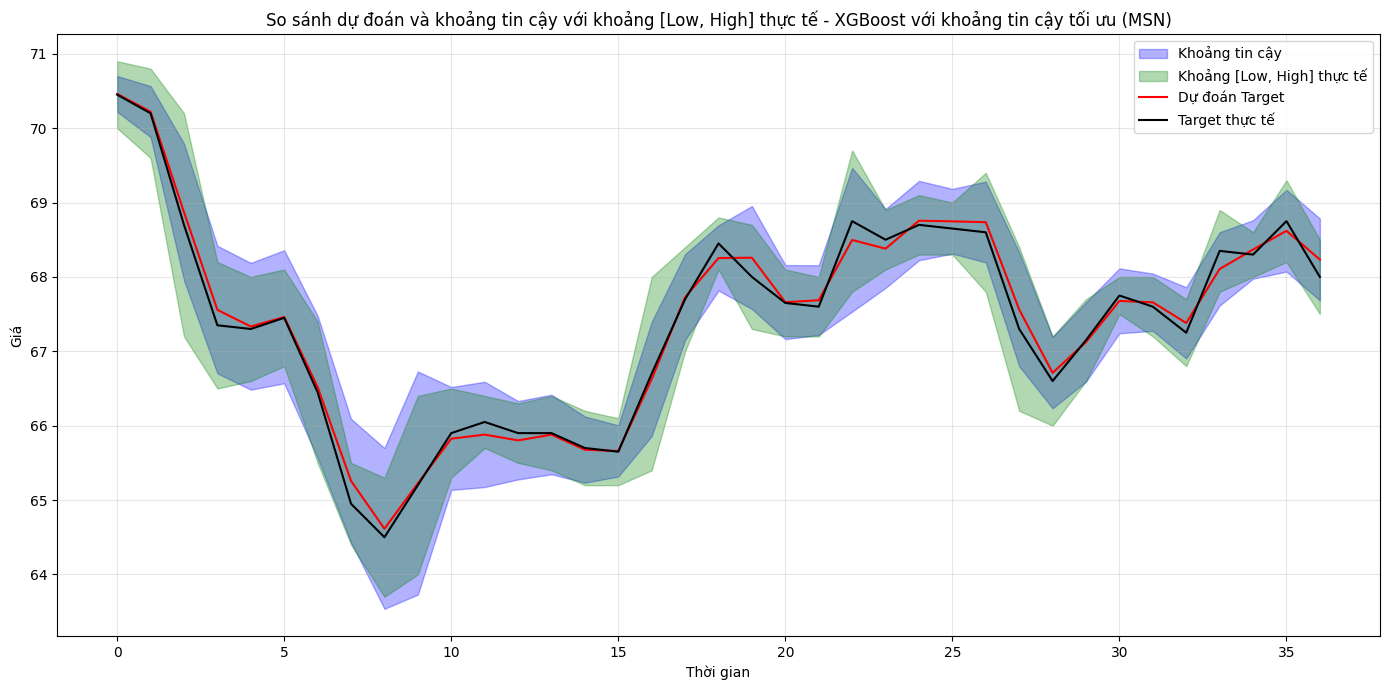

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (362, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.4604
MAPE: 0.0045
R² Score: 0.8954
Khoảng tin cậy bao phủ [Low, High]: 64.86%
Dự đoán nằm trong [Low, High]: 89.19%
Tỷ lệ độ rộng (CI/Actual): 1.6410

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.4604
MAPE: 0.0045
R² Score: 0.8954
Khoảng tin cậy b

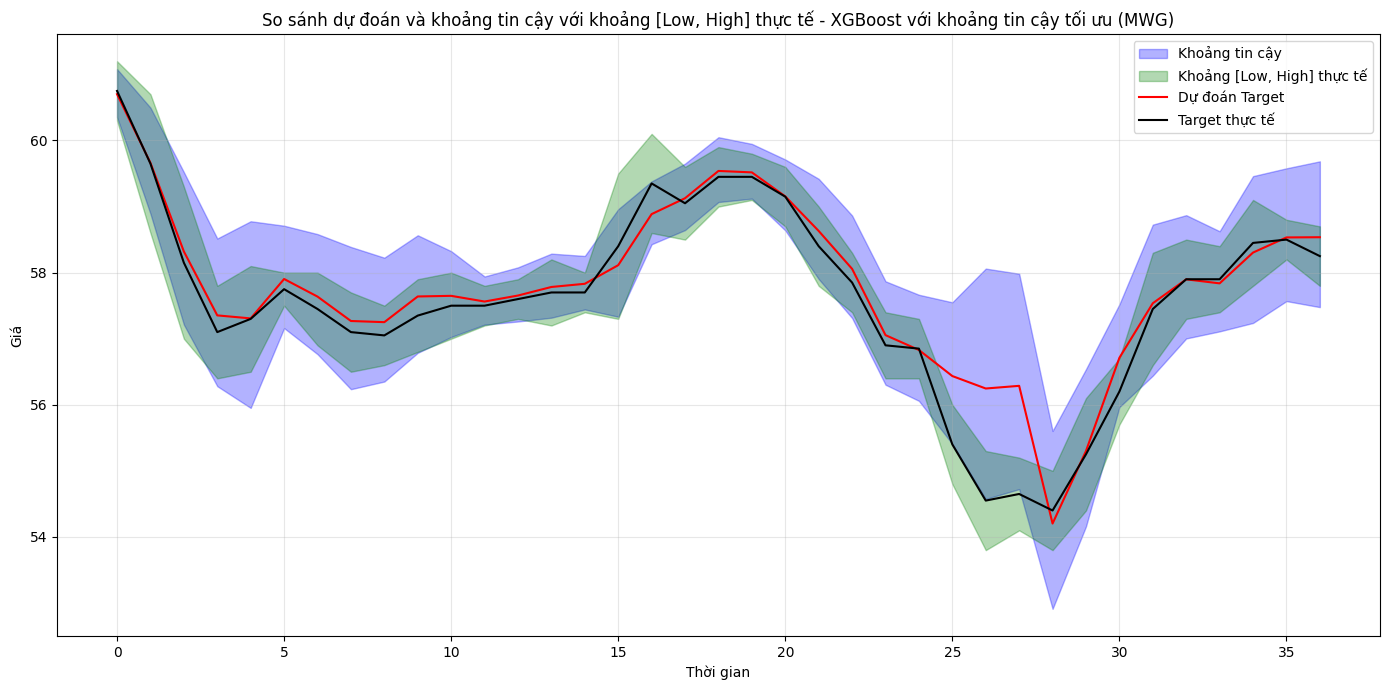

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (373, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.2108
MAPE: 0.0038
R² Score: 0.9858
Khoảng tin cậy bao phủ [Low, High]: 48.65%
Dự đoán nằm trong [Low, High]: 83.78%
Tỷ lệ độ rộng (CI/Actual): 1.5279

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.2108
MAPE: 0.0038
R² Score: 0.9858
Khoảng tin cậy b

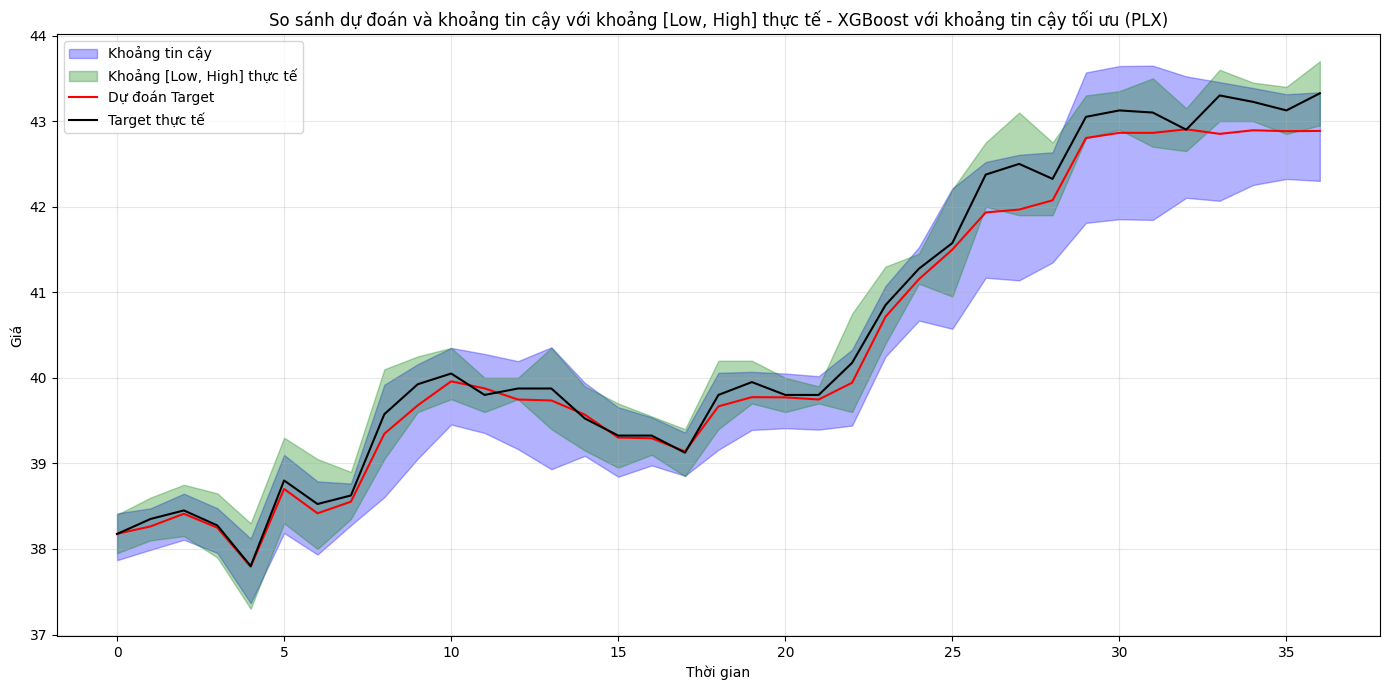

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (369, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.0958
MAPE: 0.0012
R² Score: 0.9935
Khoảng tin cậy bao phủ [Low, High]: 67.57%
Dự đoán nằm trong [Low, High]: 97.30%
Tỷ lệ độ rộng (CI/Actual): 1.4131

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.0958
MAPE: 0.0012
R² Score: 0.9935
Khoảng tin cậy b

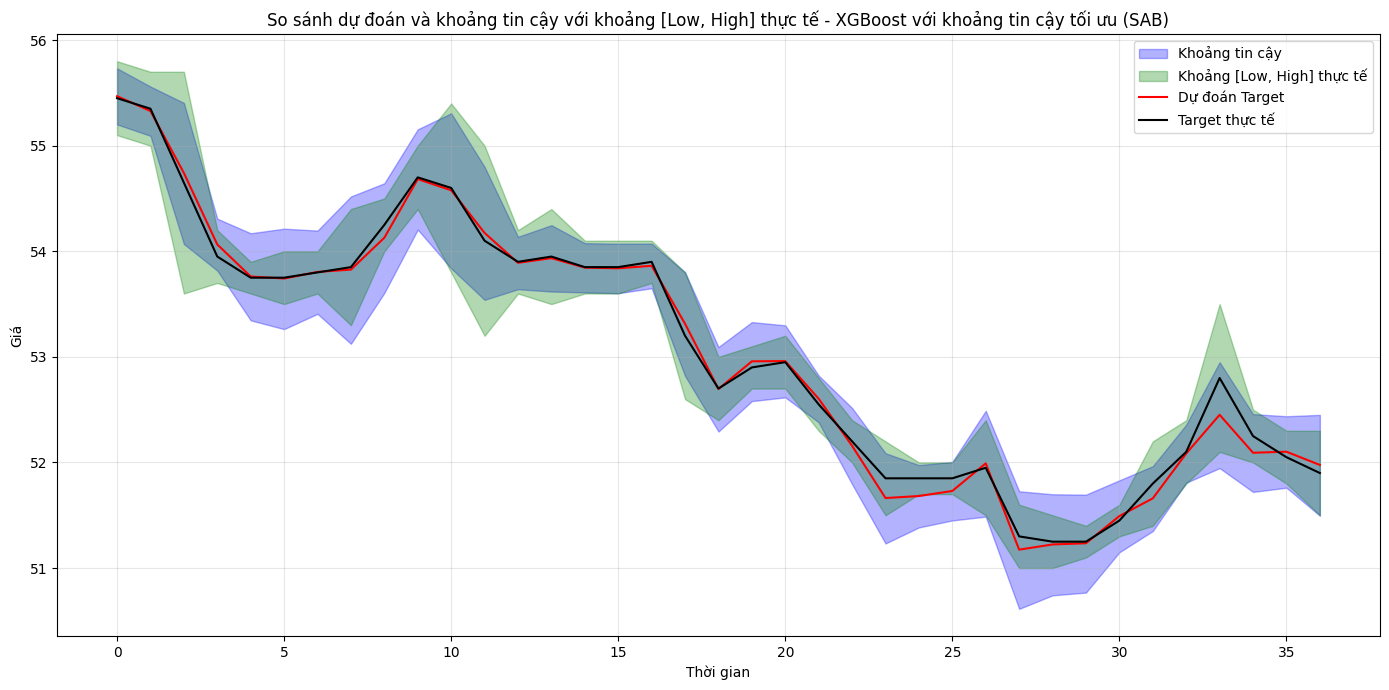

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (368, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.0242
MAPE: 0.0020
R² Score: 0.9944
Khoảng tin cậy bao phủ [Low, High]: 51.35%
Dự đoán nằm trong [Low, High]: 94.59%
Tỷ lệ độ rộng (CI/Actual): 1.4356

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.0242
MAPE: 0.0020
R² Score: 0.9944
Khoảng tin cậy b

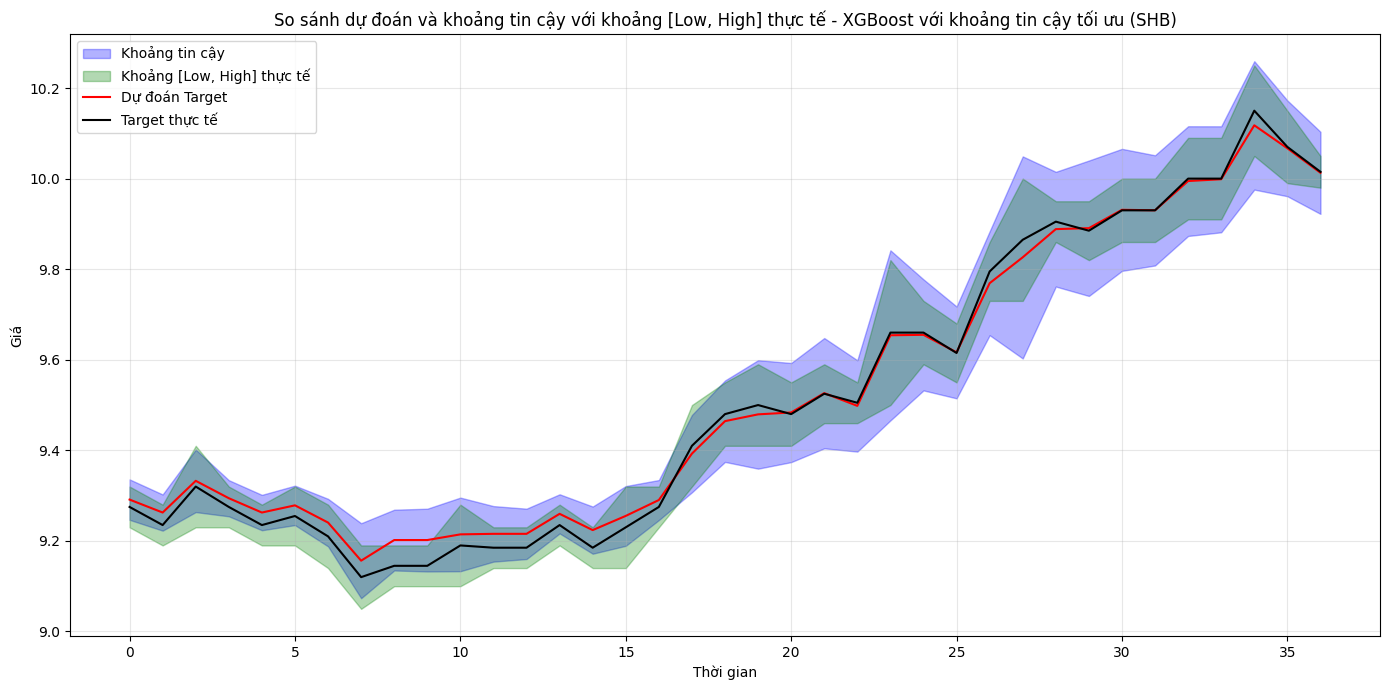

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (366, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.1278
MAPE: 0.0047
R² Score: 0.9833
Khoảng tin cậy bao phủ [Low, High]: 40.54%
Dự đoán nằm trong [Low, High]: 86.49%
Tỷ lệ độ rộng (CI/Actual): 1.1724

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.1278
MAPE: 0.0047
R² Score: 0.9833
Khoảng tin cậy b

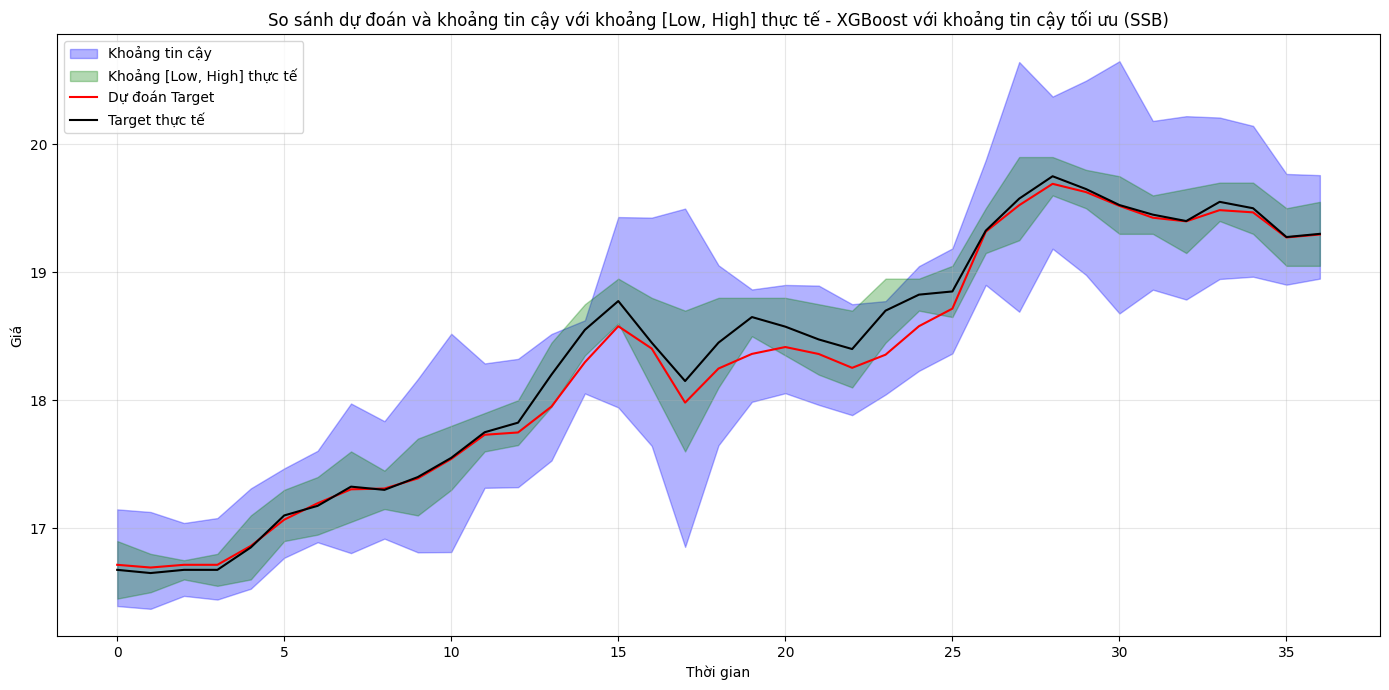

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (376, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.0387
MAPE: 0.0013
R² Score: 0.9954
Khoảng tin cậy bao phủ [Low, High]: 45.95%
Dự đoán nằm trong [Low, High]: 100.00%
Tỷ lệ độ rộng (CI/Actual): 1.2427

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.0387
MAPE: 0.0013
R² Score: 0.9954
Khoảng tin cậy 

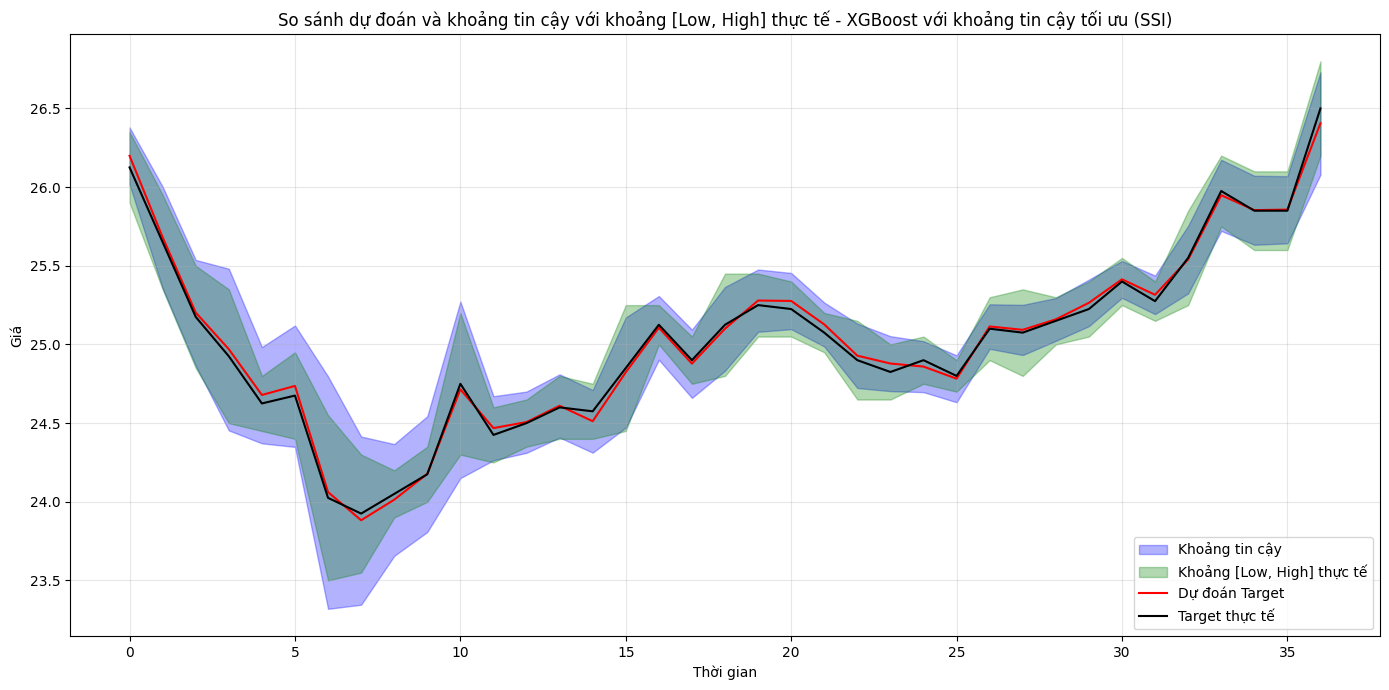

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (359, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 1.8900
MAPE: 0.0396
R² Score: -1.2091
Khoảng tin cậy bao phủ [Low, High]: 5.41%
Dự đoán nằm trong [Low, High]: 13.51%
Tỷ lệ độ rộng (CI/Actual): 0.8868

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 1.8900
MAPE: 0.0396
R² Score: -1.2091
Khoảng tin cậy 

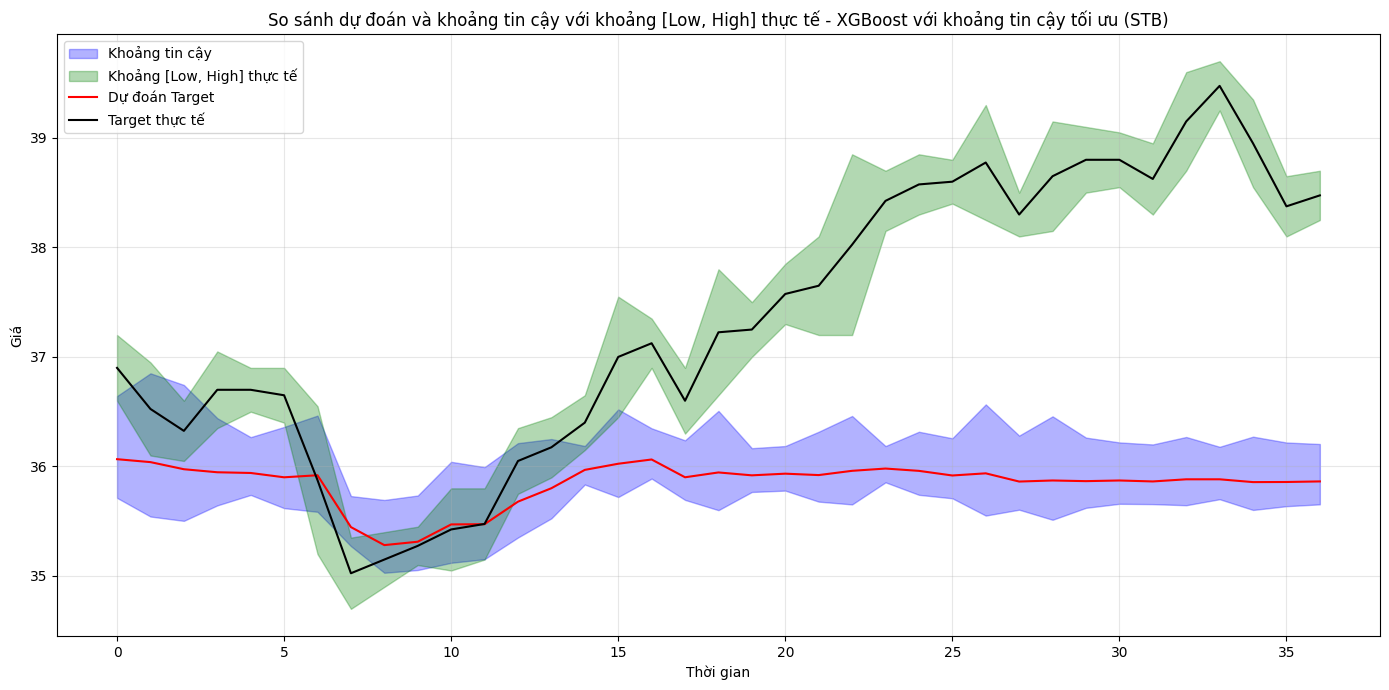

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (352, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 1.0218
MAPE: 0.0269
R² Score: 0.0163
Khoảng tin cậy bao phủ [Low, High]: 24.32%
Dự đoán nằm trong [Low, High]: 51.35%
Tỷ lệ độ rộng (CI/Actual): 1.2583

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 1.0218
MAPE: 0.0269
R² Score: 0.0163
Khoảng tin cậy b

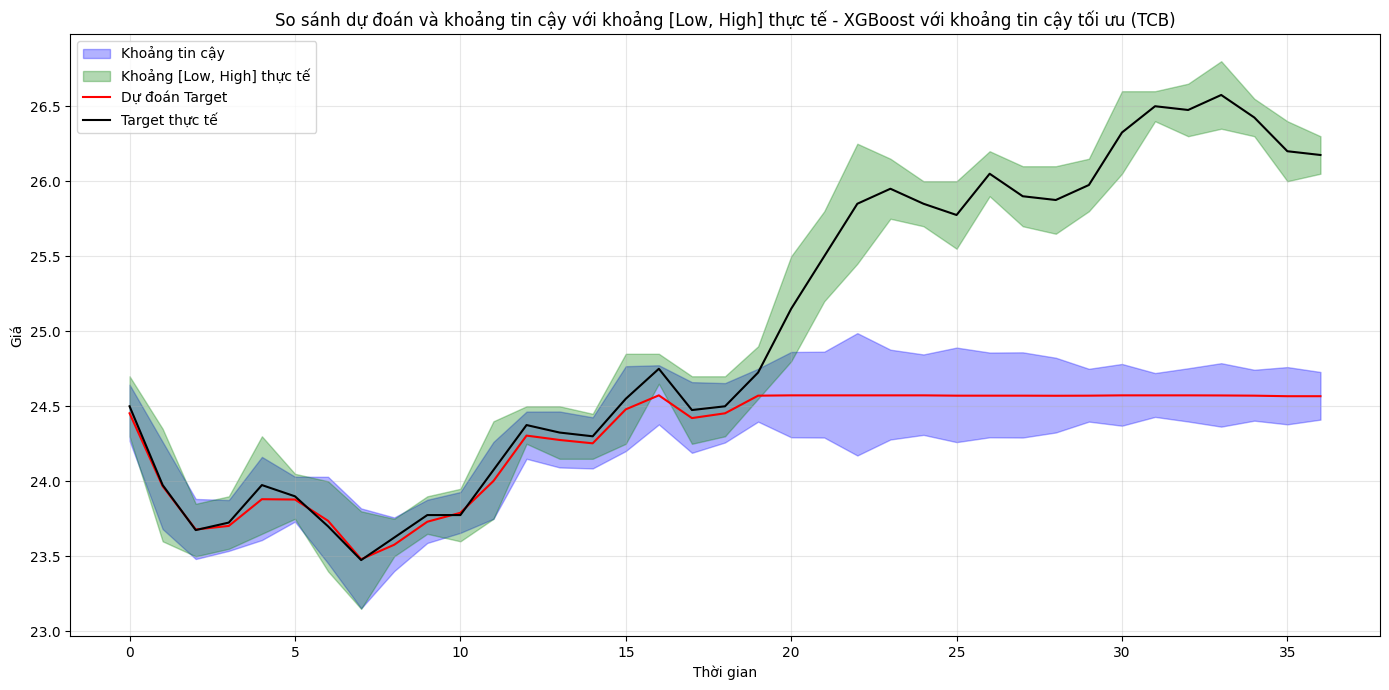

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (370, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.1167
MAPE: 0.0051
R² Score: 0.9043
Khoảng tin cậy bao phủ [Low, High]: 32.43%
Dự đoán nằm trong [Low, High]: 70.27%
Tỷ lệ độ rộng (CI/Actual): 1.2707

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.1167
MAPE: 0.0051
R² Score: 0.9043
Khoảng tin cậy b

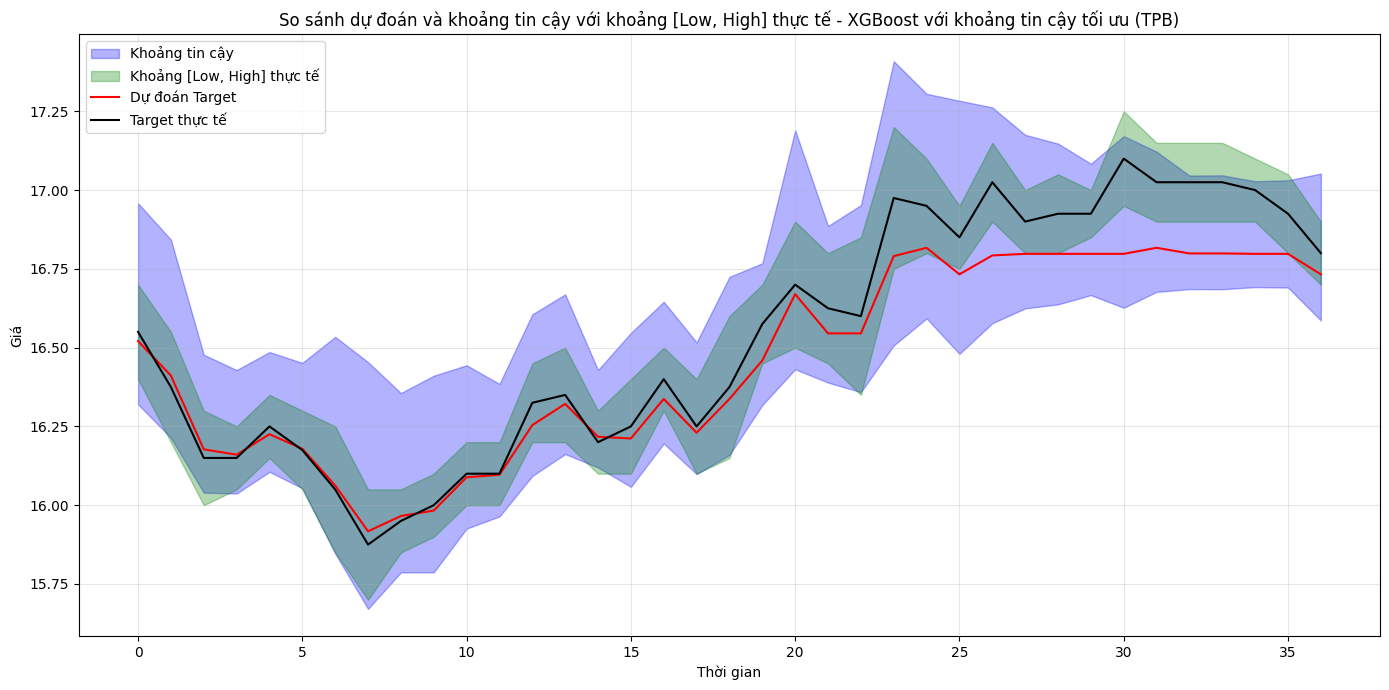

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (366, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.0573
MAPE: 0.0008
R² Score: 0.9831
Khoảng tin cậy bao phủ [Low, High]: 43.24%
Dự đoán nằm trong [Low, High]: 100.00%
Tỷ lệ độ rộng (CI/Actual): 1.2288

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.0573
MAPE: 0.0008
R² Score: 0.9831
Khoảng tin cậy 

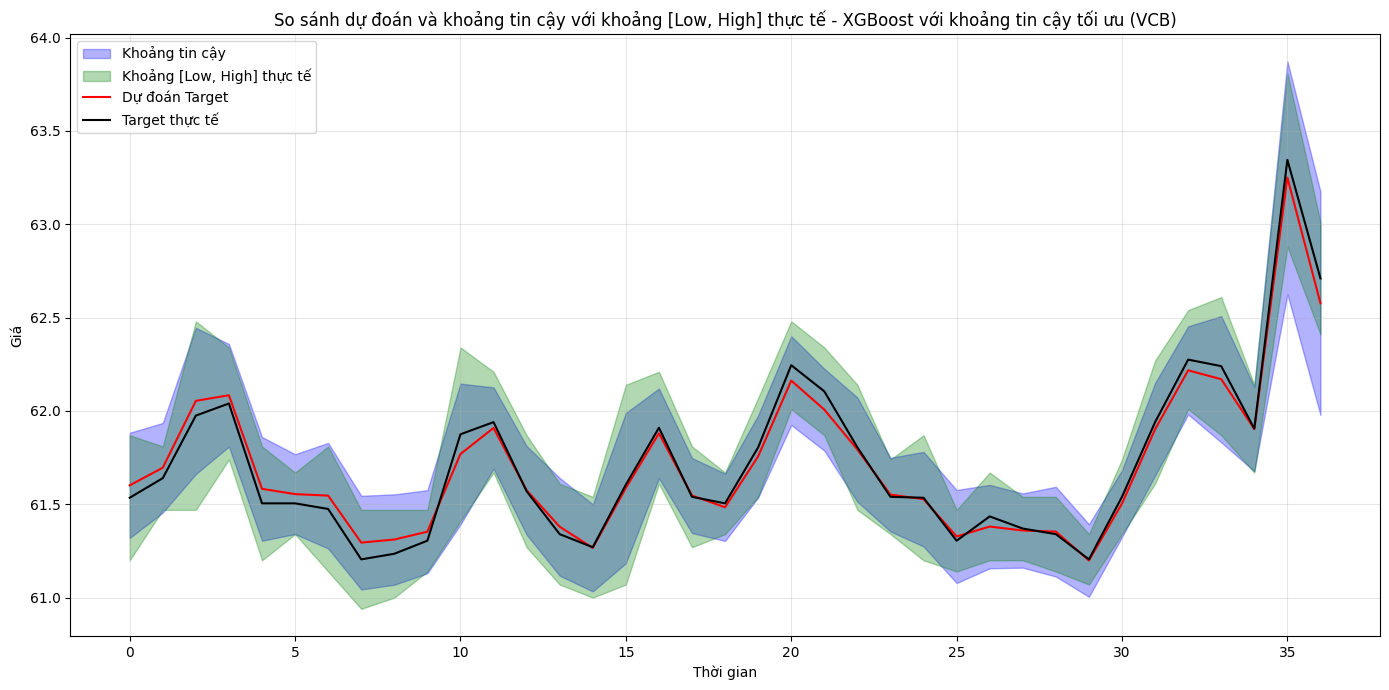

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (379, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.1114
MAPE: 0.0020
R² Score: 0.9806
Khoảng tin cậy bao phủ [Low, High]: 62.16%
Dự đoán nằm trong [Low, High]: 94.59%
Tỷ lệ độ rộng (CI/Actual): 1.4184

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.1114
MAPE: 0.0020
R² Score: 0.9806
Khoảng tin cậy b

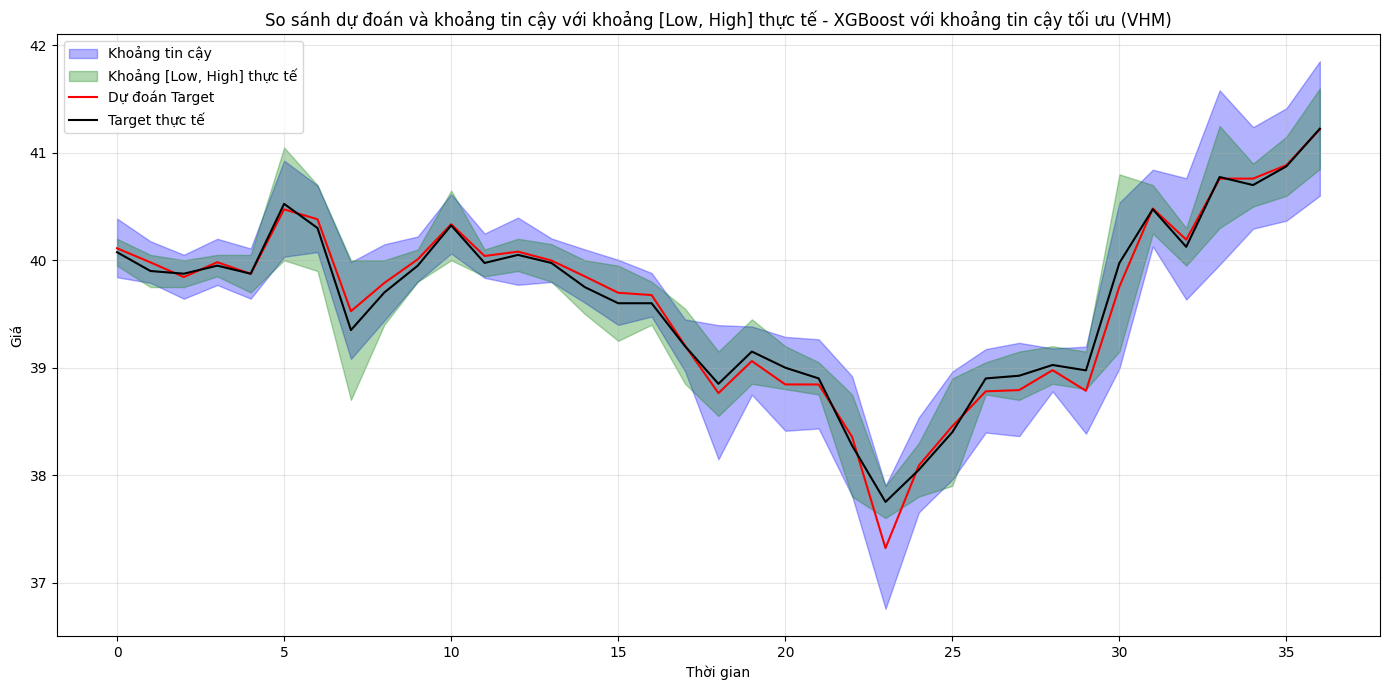

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (370, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.5704
MAPE: 0.0230
R² Score: -0.1919
Khoảng tin cậy bao phủ [Low, High]: 16.22%
Dự đoán nằm trong [Low, High]: 29.73%
Tỷ lệ độ rộng (CI/Actual): 1.2013

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.5704
MAPE: 0.0230
R² Score: -0.1919
Khoảng tin cậy

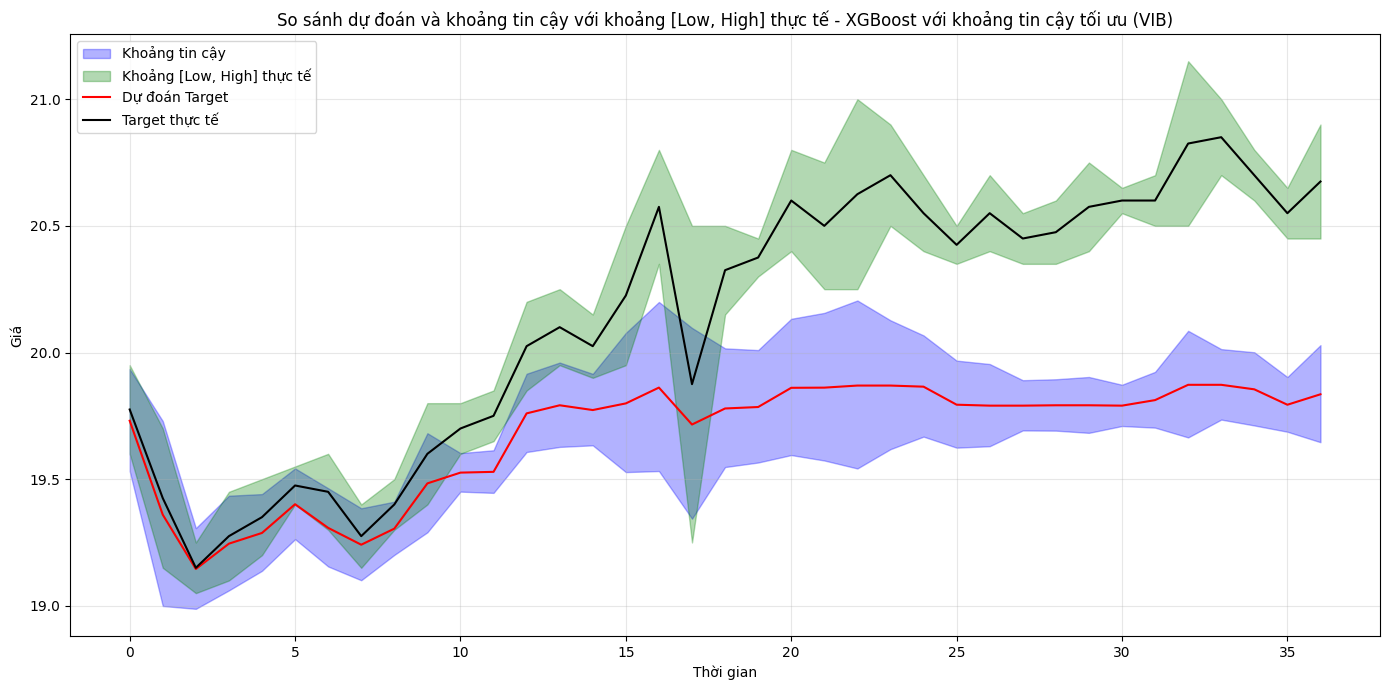

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (378, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.1881
MAPE: 0.0037
R² Score: 0.5936
Khoảng tin cậy bao phủ [Low, High]: 29.73%
Dự đoán nằm trong [Low, High]: 70.27%
Tỷ lệ độ rộng (CI/Actual): 1.4674

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.1881
MAPE: 0.0037
R² Score: 0.5936
Khoảng tin cậy b

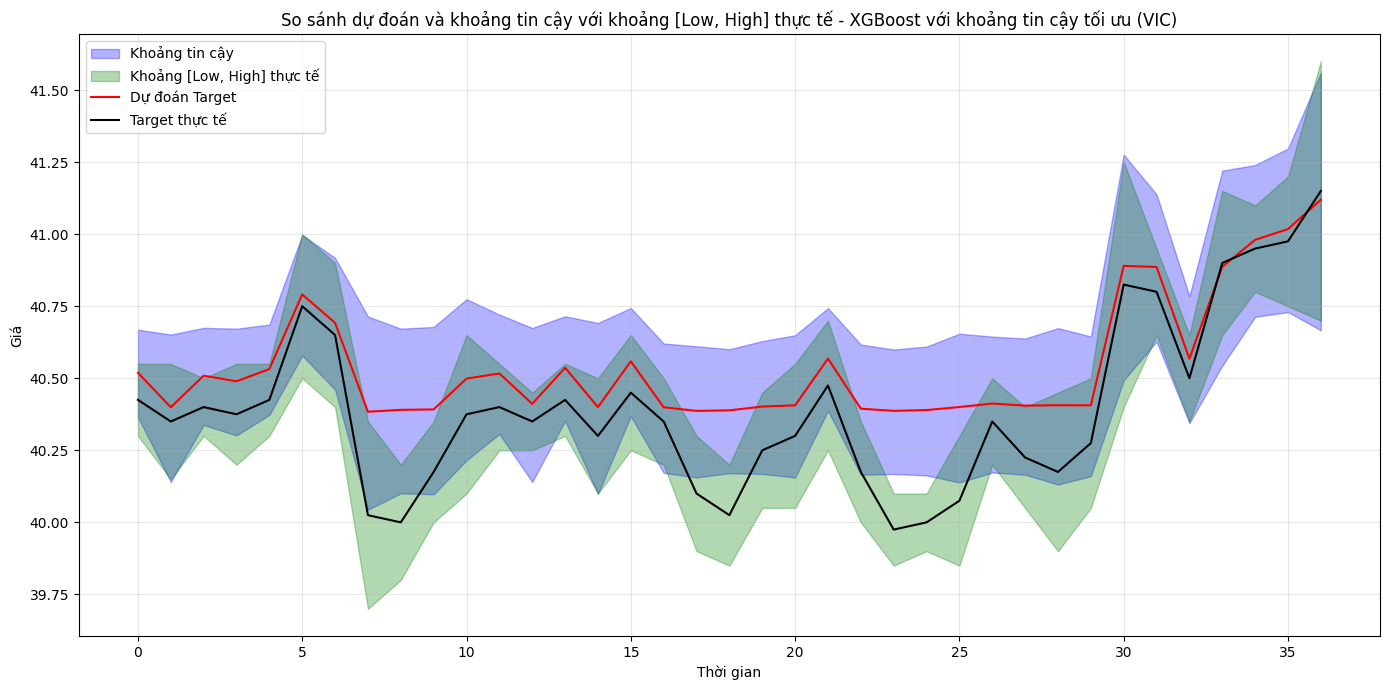

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (376, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.1164
MAPE: 0.0010
R² Score: 0.9892
Khoảng tin cậy bao phủ [Low, High]: 83.78%
Dự đoán nằm trong [Low, High]: 100.00%
Tỷ lệ độ rộng (CI/Actual): 1.5980

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.1164
MAPE: 0.0010
R² Score: 0.9892
Khoảng tin cậy 

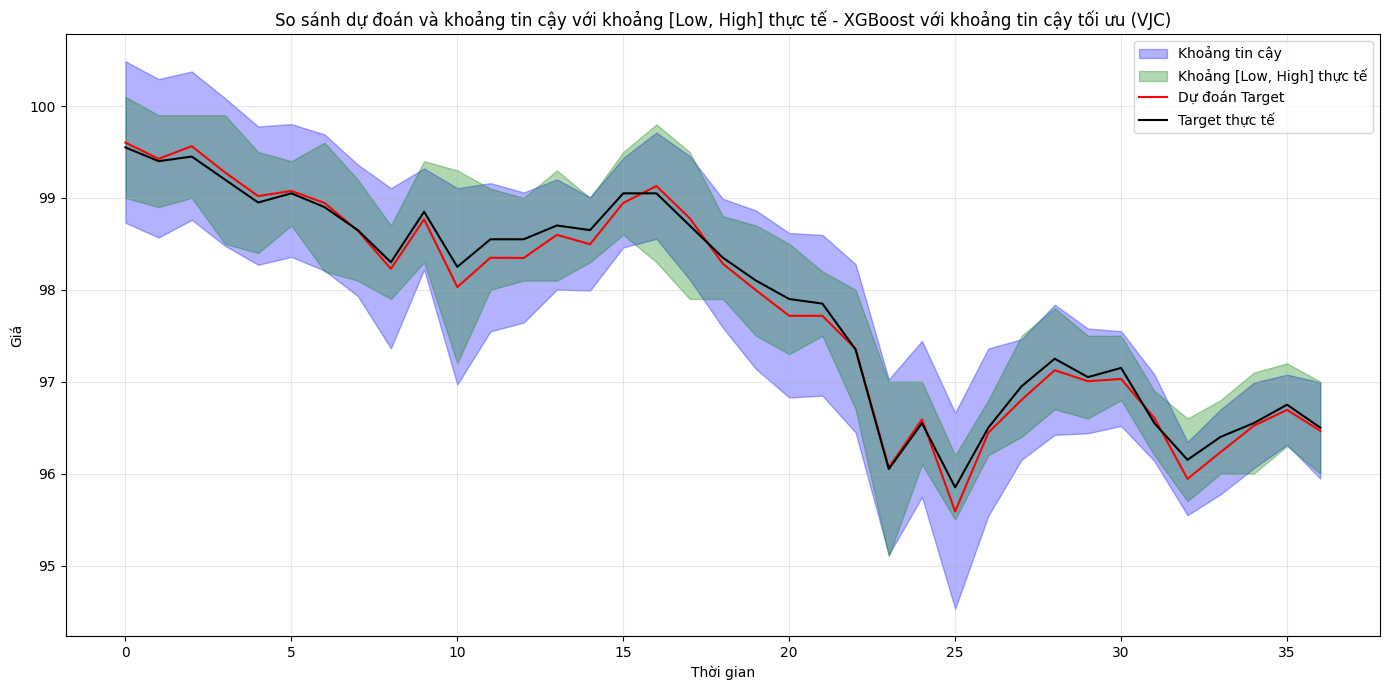

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (357, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.2471
MAPE: 0.0031
R² Score: 0.9260
Khoảng tin cậy bao phủ [Low, High]: 37.84%
Dự đoán nằm trong [Low, High]: 75.68%
Tỷ lệ độ rộng (CI/Actual): 1.2883

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.2471
MAPE: 0.0031
R² Score: 0.9260
Khoảng tin cậy b

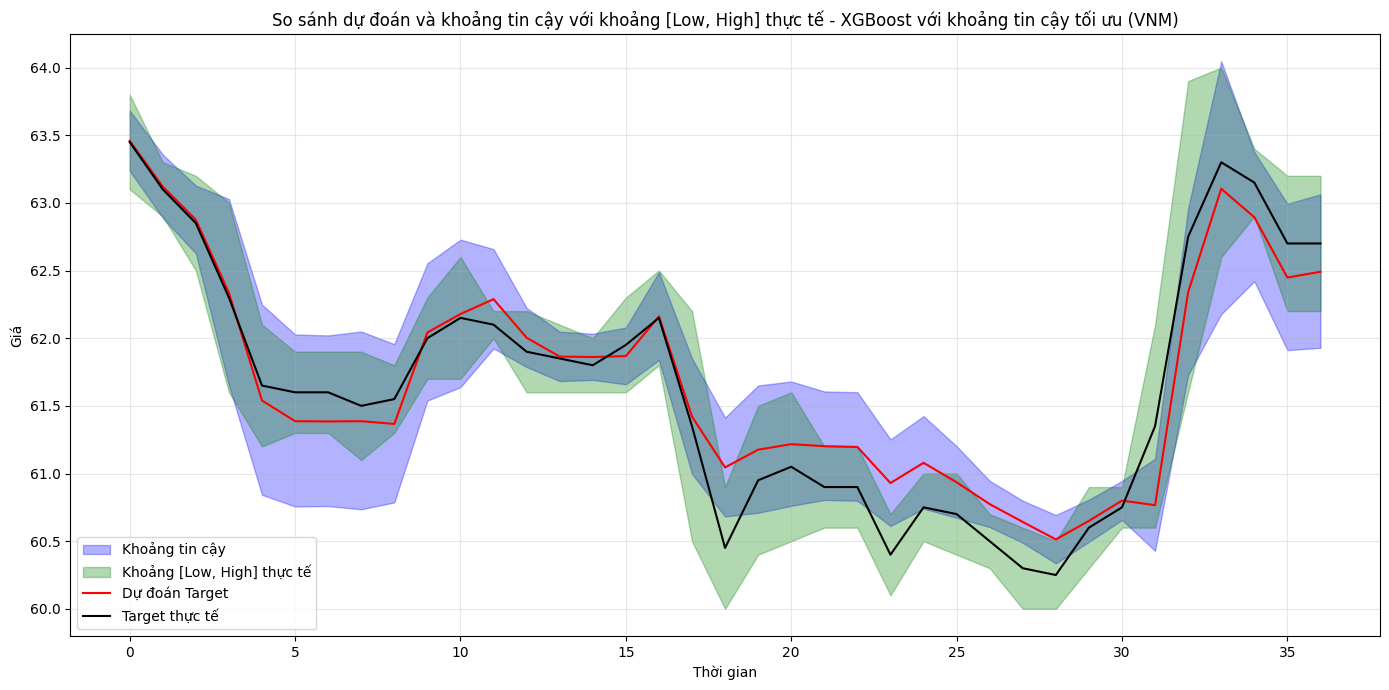

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (359, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.0174
MAPE: 0.0007
R² Score: 0.9971
Khoảng tin cậy bao phủ [Low, High]: 86.49%
Dự đoán nằm trong [Low, High]: 100.00%
Tỷ lệ độ rộng (CI/Actual): 1.4119

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.0174
MAPE: 0.0007
R² Score: 0.9971
Khoảng tin cậy 

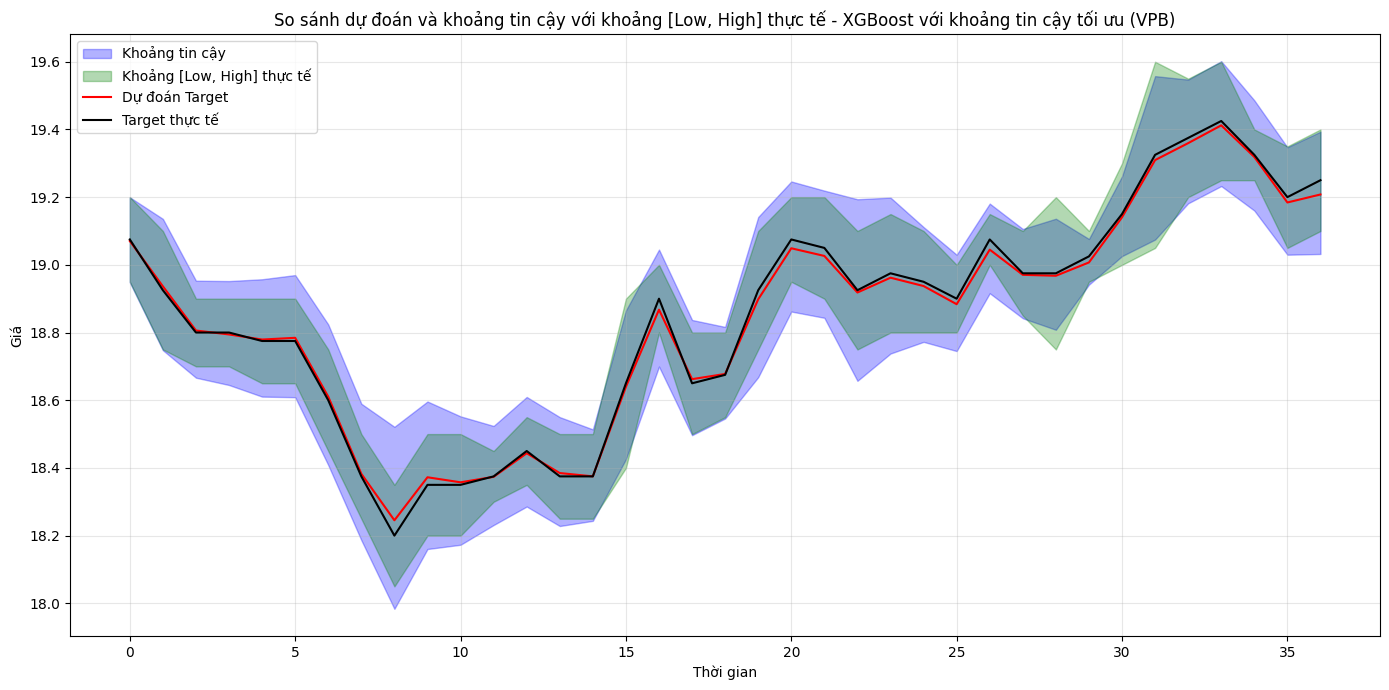

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (376, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.5674
MAPE: 0.0287
R² Score: -1.7657
Khoảng tin cậy bao phủ [Low, High]: 13.51%
Dự đoán nằm trong [Low, High]: 27.03%
Tỷ lệ độ rộng (CI/Actual): 1.0495

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.5674
MAPE: 0.0287
R² Score: -1.7657
Khoảng tin cậy

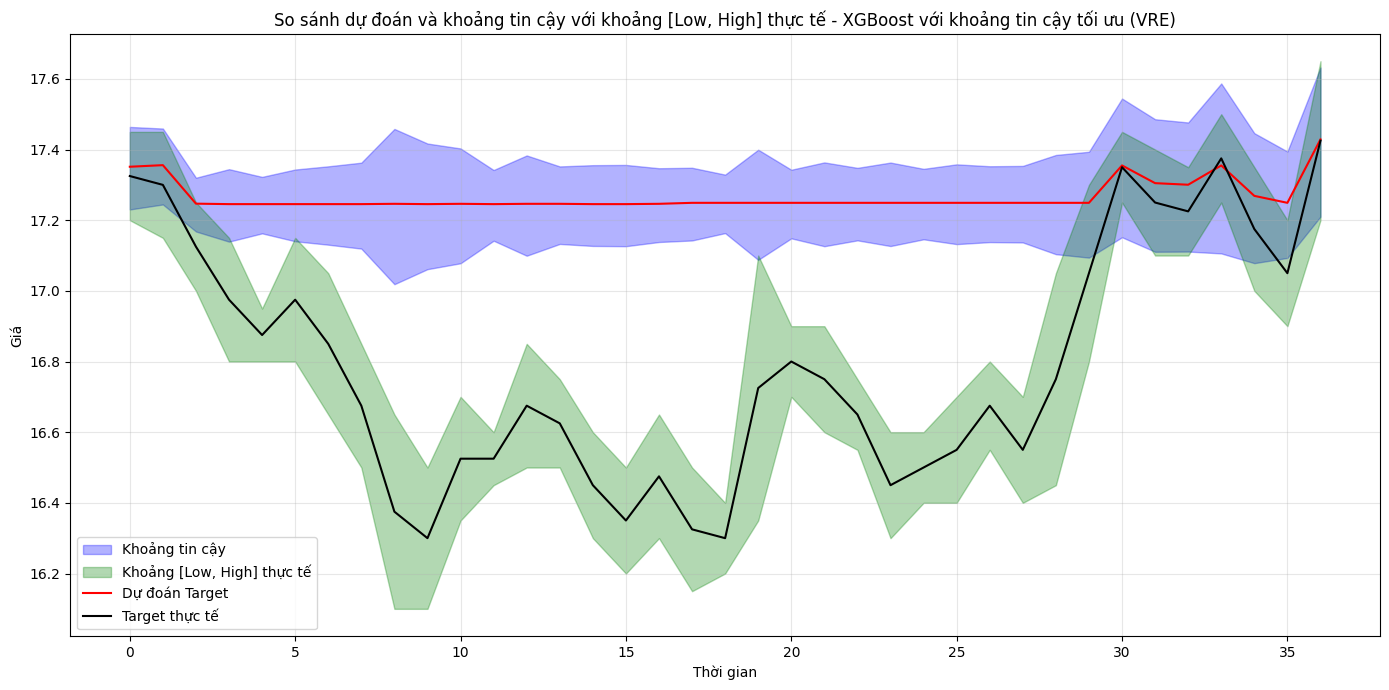

Success rate: 19/30
Average R²: 0.968798020443413


In [3]:
import warnings
warnings.filterwarnings('ignore')

success_cases = 0
avg_r2 = 0

vn30 = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']

for symbol in vn30:
	df_train = pd.read_csv(f'../data/2023/vn30/{symbol}.csv')
	df_test = pd.read_csv(f'../data/2025/vn30/{symbol}.csv')

	df_train_processed, df_test_processed = preprocess(df_train, df_test)

	# Chạy XGBoost với đầy đủ cải tiến
	results = run_enhanced_prediction(df_train_processed, df_test_processed, window_size=10, symbol=symbol)

	r2 = results['metrics']['final']['r2']
	if r2 > 0.75:
		success_cases += 1
		avg_r2 += r2

print(f"Success rate: {success_cases}/{len(vn30)}")
print(f"Average R²: {avg_r2/success_cases}")

## 2. Macro Index Prediction

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (347, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 3.4770
MAPE: 0.0013
R² Score: 0.9737
Khoảng tin cậy bao phủ [Low, High]: 75.68%
Dự đoán nằm trong [Low, High]: 86.49%
Tỷ lệ độ rộng (CI/Actual): 1.5012

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 3.4770
MAPE: 0.0013
R² Score: 0.9737
Khoảng tin cậy b

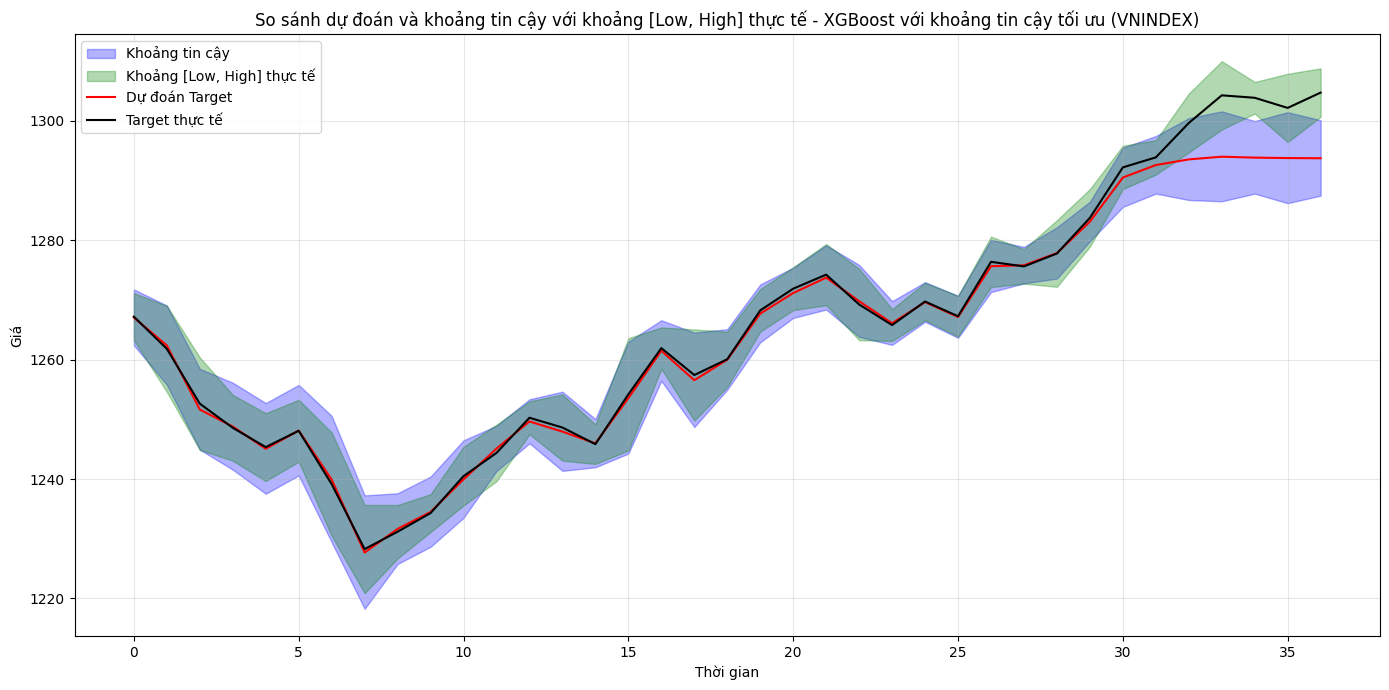

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (376, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.5068
MAPE: 0.0013
R² Score: 0.9945
Khoảng tin cậy bao phủ [Low, High]: 56.76%
Dự đoán nằm trong [Low, High]: 94.59%
Tỷ lệ độ rộng (CI/Actual): 1.1963

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.5068
MAPE: 0.0013
R² Score: 0.9945
Khoảng tin cậy b

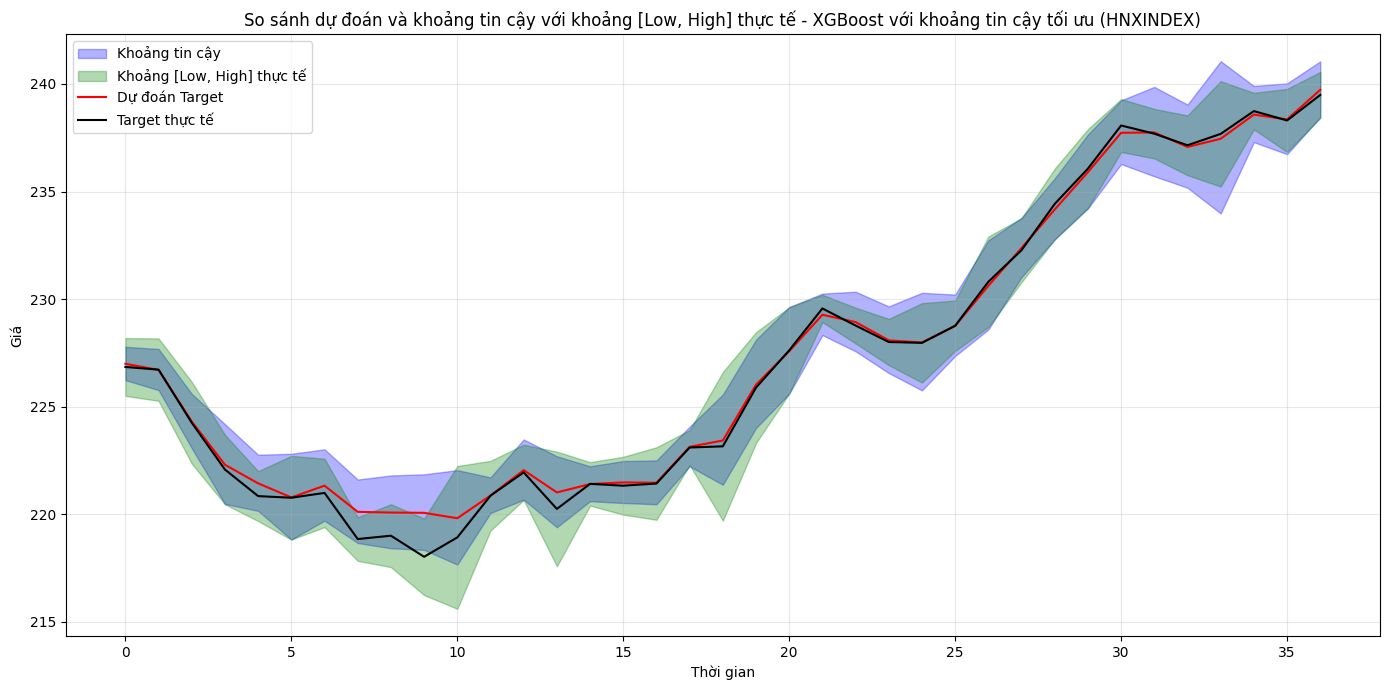

Chuẩn bị đặc trưng nâng cao cho tập train...
Chuẩn bị đặc trưng nâng cao cho tập test...
Kích thước tập train: (326, 135)
Kích thước tập test: (37, 135)
Số ngày trong df_test ban đầu: 37
Số ngày trong X_test sau xử lý: 37

Huấn luyện mô hình với hiệu chỉnh...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...
Huấn luyện mô hình Target...
Huấn luyện mô hình High...
Huấn luyện mô hình Low...
Huấn luyện mô hình độ lệch upper...
Huấn luyện mô hình độ lệch lower...

Dự đoán với các phương pháp khác nhau...
Kết hợp các dự đoán...
Tính khoảng tin cậy thích ứng...
Hiệu chỉnh khoảng tin cậy...

Đánh giá mô hình:

--- Khoảng tin cậy thích ứng ---
RMSE: 0.5227
MAPE: 0.0034
R² Score: 0.9676
Khoảng tin cậy bao phủ [Low, High]: 37.84%
Dự đoán nằm trong [Low, High]: 75.68%
Tỷ lệ độ rộng (CI/Actual): 1.4708

--- Khoảng tin cậy hiệu chỉnh ---
RMSE: 0.5227
MAPE: 0.0034
R² Score: 0.9676
Khoảng tin cậy b

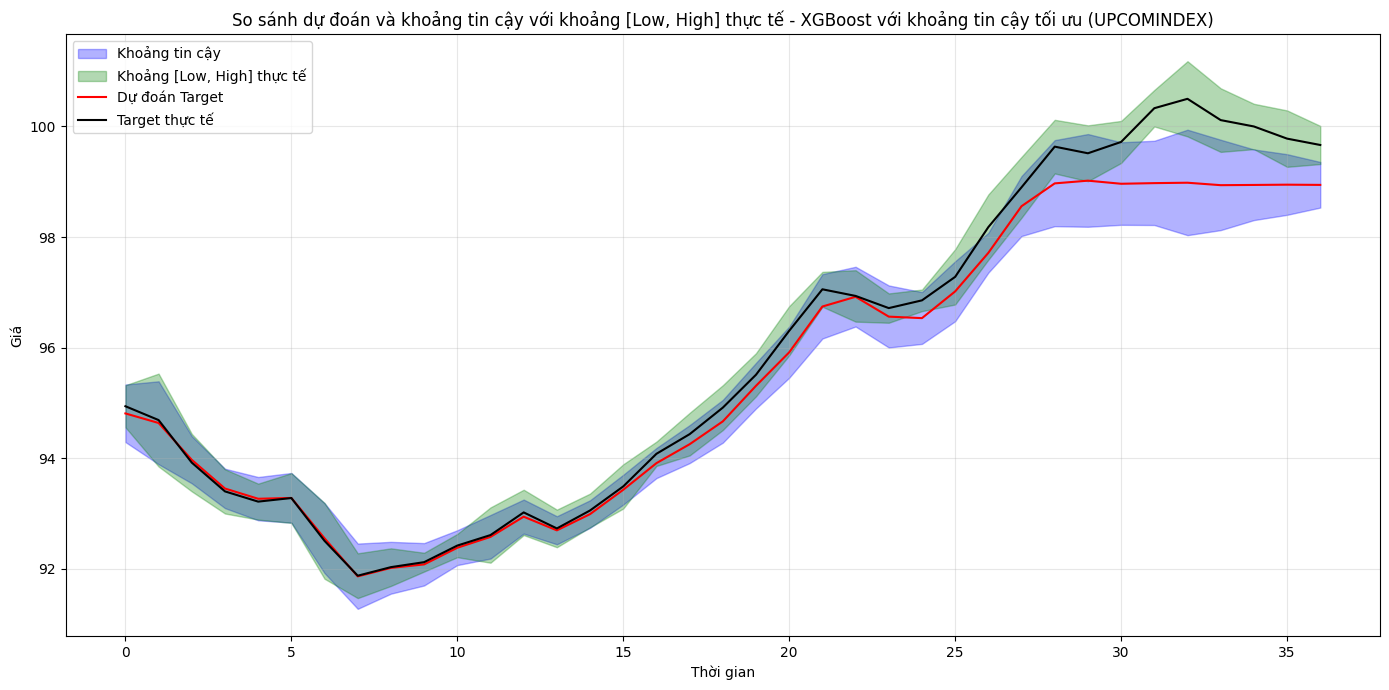

In [4]:
for index in ['VNINDEX', 'HNXINDEX', 'UPCOMINDEX']:
	df = pd.read_csv(f'../data/2023/index/{index}.csv')
	df_train = df[['time', 'high', 'low']]
	df = pd.read_csv(f'../data/2025/index/{index}.csv')
	df_test = df[['time', 'high', 'low']]

	df_train_processed, df_test_processed = preprocess(df_train, df_test)

	# Chạy XGBoost với đầy đủ cải tiến
	results = run_enhanced_prediction(df_train_processed, df_test_processed, window_size=10, symbol=index)